In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
import datetime as dt
from sqlalchemy import create_engine
import psycopg2
from dateutil.relativedelta import *
from collections import Counter
from collections import defaultdict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from pandas_profiling import profile_report
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

# Credenciales

In [2]:
# Credenciales RedShift
rs_user = 'adminperu'
rs_pass = 'PeruAnalytics2020'
rs_host = 'analytics-peru.chteoidfnecu.us-east-1.redshift.amazonaws.com'
rs_port = 5439
rs_db = 'analytics_peru'
  
engine = create_engine('postgresql://'+rs_user+':'+rs_pass+'@'+rs_host+':'+str(rs_port)+'/'+rs_db+'')

# Funciones

In [3]:
def ks_test(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['target0']=data['target0'].astype('float64')
    try:
        data['bucket'] = pd.qcut(data[prob], 10)
    except:
        data.sort_values(by = prob, ascending = False, inplace = True)
        data.reset_index(inplace = True)
        array = np.array_split(data, 10)
        data_ = pd.DataFrame()
        for i in np.arange(0,10):
            array[i]['bucket'] = i+1
            data_ = data_.append(array[i])
            data_.reset_index(drop = True, inplace = True)
        data=data_.copy()
        del data_
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 6)
    print(kstable)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

# 202205

## Evaluación modelo - full variables

In [4]:
df=pd.read_csv('/home/userbda/Documents/Modelos/modelo_contactabilidad_Outbound/outputs/preds/res_202205_26-09-2022_21:35:45_v8_traf_m2.csv.gzip',compression='gzip')
df.head()

,nro_documento_hash,nro_telefono_hash,pred,label,grupo
0,61199f23980d94e23856687559797860601bbc49b8450c...,88083f84cbe550c50eab362f18fcd32400926807b912e1...,0.577992,1,Muy alto
1,7780d68ecd487ebf07d517cdcc75419d4a316836c6c6ce...,95faf6cc63a1708b26d5362debf815b8372ab822e629c9...,0.487483,1,Medio
2,126ec7a2eb97fdf09f168410c8d848fe58ee1a11197760...,b4b900af766a00d6bea91909c47960b6db19bc7fcfd54b...,0.413201,0,Bajo
3,7df88b01f7657d70abda3a4dd0c82dccf3d1c5420a1b02...,b04abcfa49f9bd8758b3a7a8d42c9957e625ce24a01e52...,0.436825,0,Bajo
4,b474ac4ab4e90207aabf70fa19bb68441f64fb8c892c9c...,51a905f2935ff09f3bd09bf637bd775ceb747863b1eb11...,0.597195,0,Muy alto


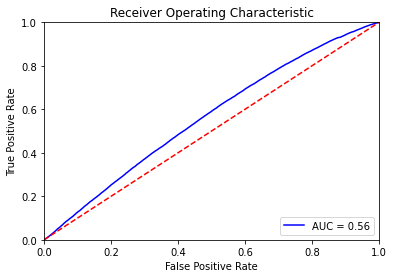

In [5]:
fpr, tpr, threshold = roc_curve(df['label'],df['pred'])
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [6]:
roc_auc_score(df['label'],df['pred'])

0.5622201221352611

In [7]:
ks=ks_test(data=df,target='label', prob='pred')
ks.to_csv('/home/userbda/Documents/Modelos/modelo_contactabilidad_Outbound/outputs/ks/ks_test_full_v8_traf_m2.csv')
ks

        min_prob  max_prob  events  ...  cum_eventrate cum_noneventrate   KS
Decile                              ...                                     
1       0.564018  0.745326    5171  ...         11.62%            9.18%  2.4
2       0.534922  0.564013    5110  ...         23.10%           18.43%  4.7
3       0.512492  0.534918    5076  ...         34.50%           27.71%  6.8
4       0.492105  0.512492    4788  ...         45.26%           37.33%  7.9
5       0.472495  0.492104    4745  ...         55.92%           46.99%  8.9
6       0.452543  0.472495    4513  ...         66.06%           56.92%  9.1
7       0.430672  0.452541    4393  ...         75.93%           66.99%  8.9
8       0.403997  0.430672    4073  ...         85.09%           77.42%  7.7
9       0.368146  0.403993    3572  ...         93.11%           88.42%  4.7
10      0.161531  0.368142    3066  ...        100.00%          100.00% -0.0

[10 rows x 9 columns]
KS is 9.1% at decile 6


,min_prob,max_prob,events,...,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,
1,0.564018,0.745326,5171,...,11.62%,9.18%,2.4
2,0.534922,0.564013,5110,...,23.10%,18.43%,4.7
3,0.512492,0.534918,5076,...,34.50%,27.71%,6.8
4,0.492105,0.512492,4788,...,45.26%,37.33%,7.9
5,0.472495,0.492104,4745,...,55.92%,46.99%,8.9
6,0.452543,0.472495,4513,...,66.06%,56.92%,9.1
7,0.430672,0.452541,4393,...,75.93%,66.99%,8.9
8,0.403997,0.430672,4073,...,85.09%,77.42%,7.7
9,0.368146,0.403993,3572,...,93.11%,88.42%,4.7


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,default_cum%_test,Base %
Decile,,
1,11.62,10
2,23.10,20
3,34.50,30
4,45.26,40
5,55.92,50
6,66.06,60
7,75.93,70
8,85.09,80
9,93.11,90


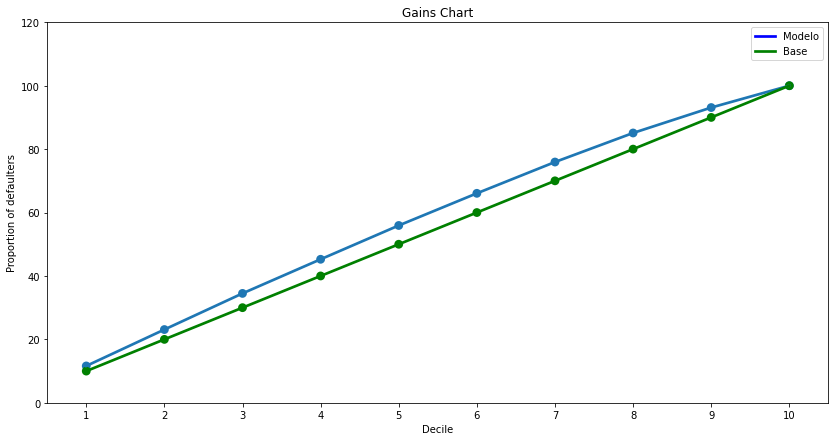

In [8]:
gain_chart=ks.copy()
gain_chart['default_cum%'] = np.round(((gain_chart['events'] / gain_chart['events'].sum()).cumsum()), 4) * 100
gain_chart2 = gain_chart[['default_cum%']]
gain_chart2.reset_index()
gain_chart2.columns = ['default_cum%_test']
gain_chart2['Base %'] = [10,20,30,40,50,60,70,80,90,100]

gain_chart2.to_csv('../outputs/gain/gain_chart_full_v8_traf_m2.csv')
display(gain_chart2)
fig, ax = plt.subplots(figsize=(14, 7), sharex=True)
sns.pointplot(data=gain_chart2.reset_index(), x='Decile', y='default_cum%_test')
sns.pointplot(data=gain_chart2.reset_index(), x='Decile', y='Base %',color='green')
ax.tick_params(axis='x')
ax.set(xlabel='Decile', ylabel='Proportion of defaulters')
ax.set_ylim(0,120)
ax.set_title('Gains Chart')
ax.legend(['Modelo','Base'],loc='best')
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('green')
plt.show()

,lift_test,Baseline
Decile,,
1,1.162000,1
2,1.155000,1
3,1.150000,1
4,1.131500,1
5,1.118400,1
6,1.101000,1
7,1.084714,1
8,1.063625,1
9,1.034556,1


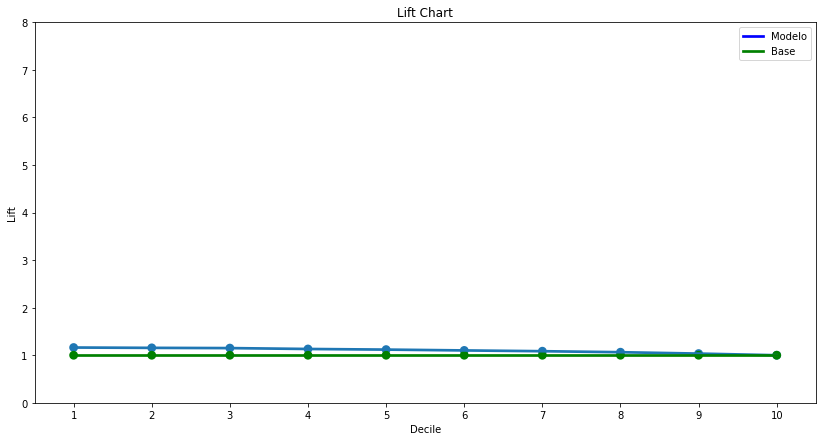

In [9]:
lift_chart=gain_chart2.copy()
lift_chart['lift_test'] = (lift_chart['default_cum%_test']/lift_chart['Base %'])
lift_chart['Baseline']  = [1,1,1,1,1,1,1,1,1,1]
lift_chart.drop(['default_cum%_test','Base %'],axis=1,inplace=True)

lift_chart.to_csv('../outputs/lift/lift_chart_full_v8_m2.csv')

display(lift_chart)

fig, ax = plt.subplots(figsize=(14, 7), sharex=True)
sns.pointplot(data=lift_chart.reset_index(), x='Decile', y='lift_test')
sns.pointplot(data=lift_chart.reset_index(), x='Decile', y='Baseline',color='green')
ax.tick_params(axis='x')
ax.set(xlabel='Decile', ylabel='Lift')
ax.set_ylim(0,8)
ax.set_title('Lift Chart')
ax.legend(['Modelo','Base'],loc='best')
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('green')
plt.show()

# 202204

In [10]:
df=pd.read_csv('../outputs/preds/res_202204_26-09-2022_21:37:27_v8_traf_m2.csv.gzip',compression='gzip')
df.head()

,nro_documento_hash,nro_telefono_hash,pred,label,grupo
0,fea9561387da2c095a81fe35d904f69113e2f1807d3453...,601064a1f85a68bc29896c9045ecdae0707b8d59a011af...,0.393771,0,Muy bajo
1,0403a1ed3a00dbcce674f525a7ffb87bb0ff158d47e38f...,4eca99268633075158240bc380b8bd0cefd186dc7fa0d1...,0.374767,0,Muy bajo
2,e5a1169206343ee80d7bfc46cc55c6e409df58d0477726...,da97723d3376e63c892c4e1647bc3ff888cbf3a68c7948...,0.418292,0,Bajo
3,3a9ed5f52fc8edc309dd3dc498e40838cc39d0125535dc...,58c7b70f9d1e3badd028584154d53f26005c01dcd9bdd6...,0.287302,0,Muy bajo
4,b9394902cd8afe4c97243b72f402d197844ead761488fa...,7eb9820d460cae073446dd5e307927c4818364c016252f...,0.363011,0,Muy bajo


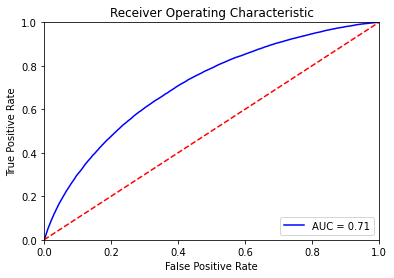

In [11]:
fpr, tpr, threshold = roc_curve(df['label'],df['pred'])
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [12]:
roc_auc_score(df['label'],df['pred'])

0.7104178841423786

In [13]:
ks=ks_test(data=df,target='label', prob='pred')
#ks.to_csv('outputs/ks/ks_test_full.csv')
print(ks)

        min_prob  max_prob  events  ...  cum_eventrate cum_noneventrate    KS
Decile                              ...                                      
1       0.574657  0.747445    9990  ...         18.39%            5.15%  13.2
2       0.544162  0.574651    8470  ...         33.97%           11.92%  22.0
3       0.519754  0.544161    7323  ...         47.45%           19.91%  27.5
4       0.497495  0.519754    6431  ...         59.29%           28.85%  30.4
5       0.475820  0.497493    5553  ...         69.51%           38.73%  30.8
6       0.452838  0.475819    4856  ...         78.44%           49.34%  29.1
7       0.427599  0.452837    4003  ...         85.81%           60.86%  24.9
8       0.397242  0.427599    3361  ...         91.99%           73.07%  18.9
9       0.354692  0.397236    2645  ...         96.86%           86.03%  10.8
10      0.149851  0.354685    1705  ...        100.00%          100.00%   0.0

[10 rows x 9 columns]
KS is 30.8% at decile 5
        min_prob 

# 202206

In [14]:
df=pd.read_csv('../outputs/preds/res_202206_26-09-2022_21:33:57_v8_traf_m2.csv.gzip',compression='gzip')
df.head()

,nro_documento_hash,nro_telefono_hash,pred,label,grupo
0,2560817d274113cf26b7a7356048d8902aa519feb1ea4c...,2ba3d65a2bfd24e3012580a79e823491a7bebec3ea3163...,0.446110,1,Medio
1,7cced77ab215edfa8d50983452fa9f81d4e392428ea2df...,956b33d2c77c73f3375fcbe8504f60e3d38e687cfed74b...,0.535655,1,Muy alto
2,bb809ae6d25960b6276e7e829fe279379cab14bd232edc...,8d497f9550362205f10bcb6944f5fd7a94e110dac9b13b...,0.346276,0,Muy bajo
3,af1635b5ea60599e5b810a1f106a3b747dd6d7fc5de28e...,7e5a593288c464b32dbb4b0c3d4cdf8e8b0cb04df86e09...,0.468562,1,Medio
4,6dab3e4e4ae07c848de54302275a978b0e747463e323bb...,79a025341ba671dc4f3a59cbcd232c1e39dfbea2e1fb18...,0.384815,0,Muy bajo


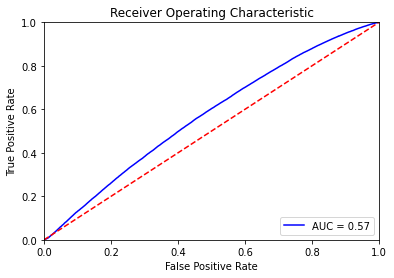

In [15]:
fpr, tpr, threshold = roc_curve(df['label'],df['pred'])
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [18]:
roc_auc_score(df['label'],df['pred'])

0.570432532378675

In [16]:
ks=ks_test(data=df,target='label', prob='pred')
ks.to_csv('../outputs/ks/ks_test_full_v8_traf_m2_202206.csv')
print(ks)

        min_prob  max_prob  events  ...  cum_eventrate cum_noneventrate    KS
Decile                              ...                                      
1       0.545788  0.742992    7211  ...         11.97%            9.14%   2.8
2       0.518858  0.545786    7208  ...         23.94%           18.28%   5.7
3       0.498648  0.518858    6977  ...         35.52%           27.59%   7.9
4       0.480773  0.498647    6589  ...         46.45%           37.19%   9.3
5       0.463569  0.480771    6442  ...         57.15%           46.88%  10.3
6       0.445620  0.463568    5985  ...         67.08%           56.91%  10.2
7       0.425904  0.445619    5811  ...         76.73%           67.07%   9.7
8       0.402064  0.425903    5567  ...         85.97%           77.40%   8.6
9       0.367570  0.402056    4743  ...         93.84%           88.32%   5.5
10      0.171868  0.367568    3709  ...        100.00%          100.00%  -0.0

[10 rows x 9 columns]
KS is 10.299999999999999% at decile 5
   

# Trains vs Test

In [17]:
df0=pd.read_csv('../outputs/preds/res_202202_26-09-2022_21:40:36_v8_traf_m2.csv.gzip',compression='gzip')
df1=pd.read_csv('../outputs/preds/res_202203_26-09-2022_21:39:37_v8_traf_m2.csv.gzip',compression='gzip')
df2=pd.read_csv('../outputs/preds/res_202204_26-09-2022_21:37:27_v8_traf_m2.csv.gzip',compression='gzip')
df3=pd.read_csv('../outputs/preds/res_202205_26-09-2022_21:35:45_v8_traf_m2.csv.gzip',compression='gzip')
df4=pd.read_csv('../outputs/preds/res_202206_26-09-2022_21:33:57_v8_traf_m2.csv.gzip',compression='gzip')
df_train=pd.concat([df0,df1,df2])

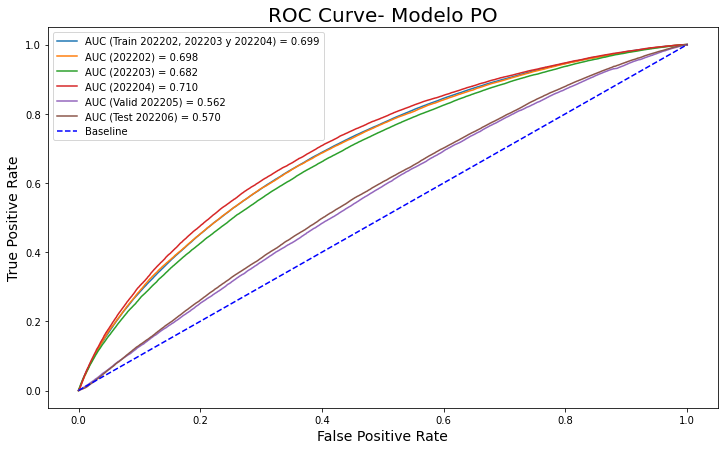

In [18]:
auc_train = roc_auc_score(df_train['label'],df_train['pred'])
fpr_train, tpr_train, thresholds_train = roc_curve(df_train['label'],df_train['pred'])

auc_df0 = roc_auc_score(df0['label'],df0['pred'])
fpr_df0, tpr_df0, thresholds_df0 = roc_curve(df0['label'],df0['pred'])

auc_df1 = roc_auc_score(df1['label'],df1['pred'])
fpr_df1, tpr_df1, thresholds_df1 = roc_curve(df1['label'],df1['pred'])

auc_df2 = roc_auc_score(df2['label'],df2['pred'])
fpr_df2, tpr_df2, thresholds_df2 = roc_curve(df2['label'],df2['pred'])

auc_df3 = roc_auc_score(df3['label'],df3['pred'])
fpr_df3, tpr_df3, thresholds_df3 = roc_curve(df3['label'],df3['pred'])

auc_df4 = roc_auc_score(df4['label'],df4['pred'])
fpr_df4, tpr_df4, thresholds_df4 = roc_curve(df4['label'],df4['pred'])

plt.figure(figsize=(12, 7))
plt.plot(fpr_train, tpr_train, label=f'AUC (Train 202202, 202203 y 202204) = {auc_train:.3f}')
plt.plot(fpr_df0, tpr_df0, label=f'AUC (202202) = {auc_df0:.3f}')
plt.plot(fpr_df1, tpr_df1, label=f'AUC (202203) = {auc_df1:.3f}')
plt.plot(fpr_df2, tpr_df2, label=f'AUC (202204) = {auc_df2:.3f}')
plt.plot(fpr_df3, tpr_df3, label=f'AUC (Valid 202205) = {auc_df3:.3f}')
plt.plot(fpr_df4, tpr_df4, label=f'AUC (Test 202206) = {auc_df4:.3f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve- Modelo PO', size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend()

# Análisis de variables importantes

In [3]:
df_iv=pd.read_csv('/home/userbda/Documents/Modelos/modelo_contactabilidad_Outbound/outputs/imp_variables/importancia_variables_26-09-2022_21:30:23_v8_traf_m2.csv')
variables=list(df_iv.iloc[:20,0])
df_iv.head(20)

,Unnamed: 0,importance
0,messenger_paginas,559
1,callcenter_llamadas_m_1,558
2,callcenter_llamadas,492
3,segundos_baja_m_1,455
4,segundos_baja,452
5,videoconf_paginas,417
6,instagram_paginas,392
7,llamadas_ent_m_1,344
8,spotify_paginas,344
9,segundos_marcador,337


In [4]:
sql=f"""
select nro_telefono_hash,
nro_documento_hash,
{variables[0]},
{variables[1]},
{variables[2]},
{variables[3]},
{variables[4]},
{variables[5]},
{variables[6]},
{variables[7]},
{variables[8]},
{variables[9]},
{variables[10]},
{variables[11]},
{variables[12]},
{variables[13]},
{variables[14]},
{variables[15]},
{variables[16]},
{variables[17]},
{variables[18]},
{variables[19]},
target_out_m2
from 
public.PER_MODELO_CONTACT_OUT3
where periodo='2022-05-01'
and target_out_m2 is not null
"""
df_temp = pd.read_sql_query(sql, engine)
df_score=pd.read_csv('../outputs/preds/res_202205_26-09-2022_21:35:45_v8_traf_m2.csv.gzip',compression='gzip')
df=df_temp.merge(df_score,how='left',on='nro_telefono_hash').drop(columns=['nro_documento_hash_y'])
df.head()

,nro_telefono_hash,nro_documento_hash_x,messenger_paginas,callcenter_llamadas_m_1,callcenter_llamadas,segundos_baja_m_1,segundos_baja,videoconf_paginas,instagram_paginas,llamadas_ent_m_1,spotify_paginas,segundos_marcador,avg_download_rate,instagram_upload,youtube_download,segundos_alta,onlineshops_paginas,avg_min_kbps_th,facebook_paginas,total_traffic,videoconf_upload,avg_traffic_median,target_out_m2,pred,label,grupo
0,fbf484f34a237079a482b476e26ed203f6515b40c60aff...,6265426b547a708d10def369e27853343869838f36146c...,871.0,12,6,14267,7841,93.0,500.0,77,622.0,1964,445.219553,12.76972,3106.12978,53660,7.0,2983.718571,8359.0,7919.71,0.003805,15.815714,1,0.513877,1,Alto
1,ea0e8b29ec9c63025148766ced36598f959e7b4b2b72c8...,b15f622b2ab845939d96e952bfc13c0919e21bb1dfcdeb...,0.0,34,41,3695,4114,320.0,213.0,107,10.0,0,39.464168,4.18579,162.50065,1629,10.0,3376.837059,408.0,475.34,0.023807,3.085294,0,0.406329,0,Bajo
2,55368bec613cd728390eb21e8b730dbf9aee5ac0066701...,1b4adb097b6b5f4e336ce22f2157d0c164eb58f659247e...,747.0,3,3,18890,16108,158.0,659.0,163,2.0,6769,622.037468,1.75482,20849.85895,150472,55.0,1625.332069,9592.0,14411.81,0.476847,6.188621,1,0.558748,1,Muy alto
3,aa0fda6f80b76ffa33521f95d6f76bdbb6ad479610fb60...,e047fa719260a10c7ce7cd7a55e3cd782334beae5f6eb6...,1199.0,1,51,11468,15920,759.0,1976.0,83,0.0,0,121.776110,31.31207,978.70272,49476,10.0,2777.892632,7278.0,1185.12,0.041961,18.473158,1,0.362721,1,Muy bajo
4,2ac579bf0503f21117561ac6ed23bdab7ffc58ac3f85d7...,8268cb31a2d3e434779a283df49e18b46fe356209157f9...,135.0,8,6,5829,10542,71.0,39.0,84,2.0,0,11.375290,0.01894,80.94547,5214,0.0,4302.815000,1104.0,54.50,0.004254,2.545000,0,0.565678,0,Muy alto


In [5]:
df['grupo'] = pd.cut(df.pred,
        bins=[-1, df['pred'].quantile(0.1), df['pred'].quantile(0.2), df['pred'].quantile(0.3), 
        df['pred'].quantile(0.4), df['pred'].quantile(0.5), df['pred'].quantile(0.6), df['pred'].quantile(0.7),
        df['pred'].quantile(0.8),df['pred'].quantile(0.9), 1],
        labels=['Decil 10','Decil 9','Decil 8','Decil 7','Decil 6','Decil 5','Decil 4','Decil 3','Decil 2','Decil 1'])

In [6]:
numericas=list(set(df.select_dtypes(exclude='object').columns).intersection(set(variables)))

In [7]:
numericas

['callcenter_llamadas_m_1',
 'instagram_paginas',
 'youtube_download',
 'facebook_paginas',
 'segundos_baja_m_1',
 'segundos_alta',
 'avg_download_rate',
 'segundos_baja',
 'segundos_marcador',
 'avg_traffic_median',
 'spotify_paginas',
 'onlineshops_paginas',
 'videoconf_upload',
 'avg_min_kbps_th',
 'videoconf_paginas',
 'total_traffic',
 'callcenter_llamadas',
 'instagram_upload',
 'messenger_paginas',
 'llamadas_ent_m_1']

## lineplot

In [9]:
df['canal_venta_base']=np.where(df['canal_venta_base']=='','VACIO',df['canal_venta_base'])

In [20]:
df['canal_venta_base']=np.where(df['canal_venta_base'].isin(list(df.canal_venta_base.value_counts()[:8].index)),df['canal_venta_base'],'OTROS')

In [5]:
df_train['grupo'] = pd.cut(df_train.pred,
        bins=[-1, df_train['pred'].quantile(0.1), df_train['pred'].quantile(0.2), df_train['pred'].quantile(0.3), df_train['pred'].quantile(0.4), df_train['pred'].quantile(0.5), 
                df_train['pred'].quantile(0.6), df_train['pred'].quantile(0.7), df_train['pred'].quantile(0.8), df_train['pred'].quantile(0.9), 1],
        labels=['Decil 10','Decil 9','Decil 8','Decil 7','Decil 6','Decil 5','Decil 4','Decil 3','Decil 2','Decil 1'])

In [16]:
df.groupby(['grupo','lin_antiguedad_month'],as_index=False)['label'].mean()

,grupo,lin_antiguedad_month,label
0,Quintil 5,1.0,0.002079
1,Quintil 5,2.0,0.002425
2,Quintil 5,3.0,0.002069
3,Quintil 5,4.0,0.001288
4,Quintil 5,5.0,0.000791
...,...,...,...
715,Quintil 1,142.0,NaN
716,Quintil 1,143.0,NaN
717,Quintil 1,145.0,NaN
718,Quintil 1,146.0,NaN


In [17]:
canal_group = df[df['lin_antiguedad_month']!='VACIO'].groupby(['grupo','canalin_antiguedad_monthl_venta_base'],as_index=False)['label'].mean()
plt.figure(figsize=(16,10))
sns.lineplot(data=canal_group, x="grupo", y="label",hue="lin_antiguedad_month")
plt.show()

KeyError: 'canalin_antiguedad_monthl_venta_base'

## Boxplots

Por Target

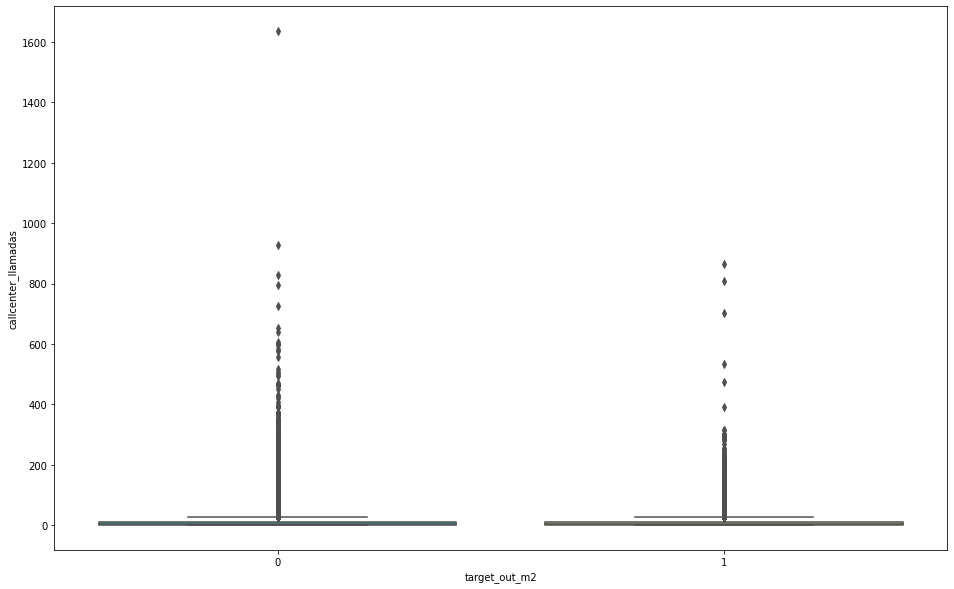

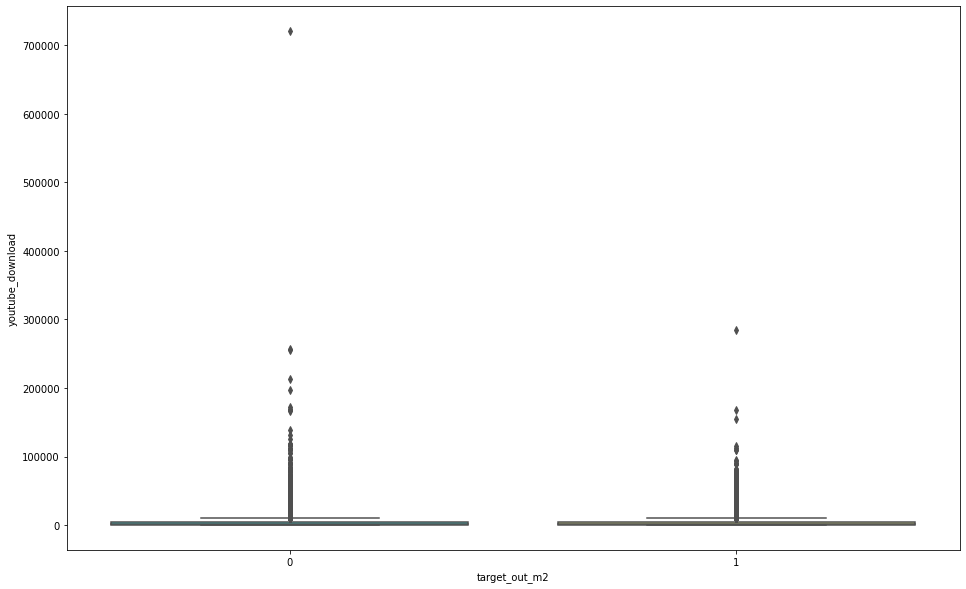

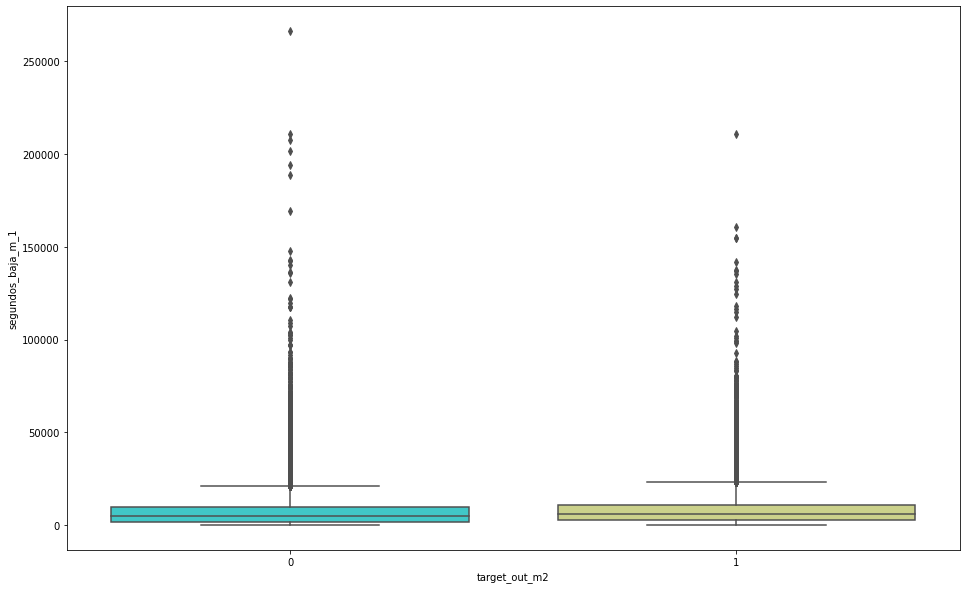

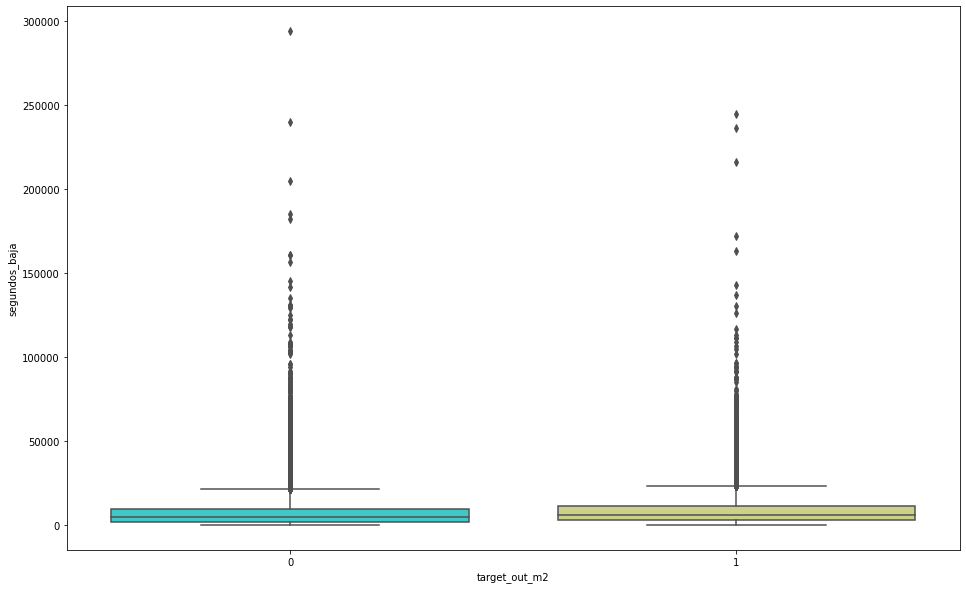

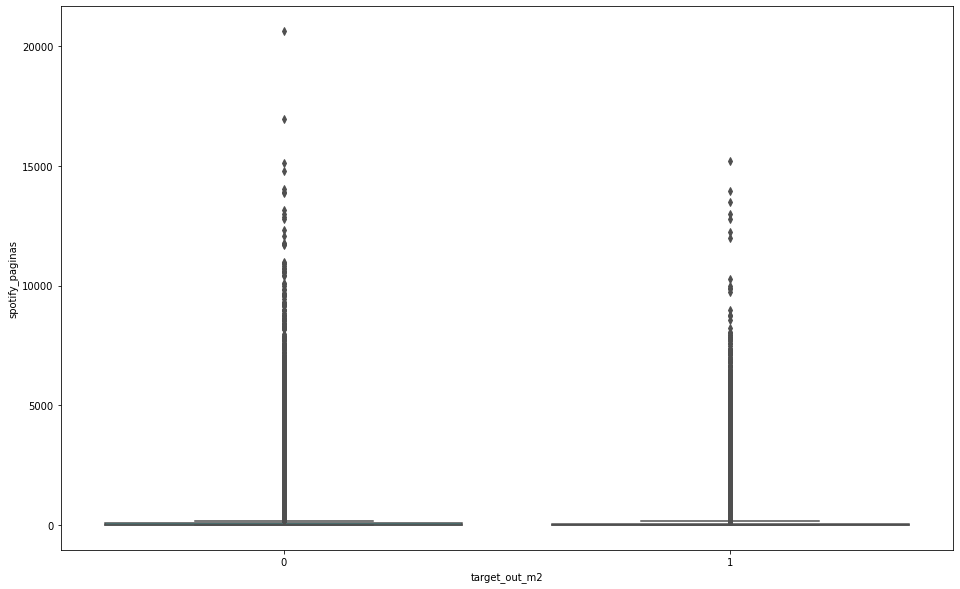

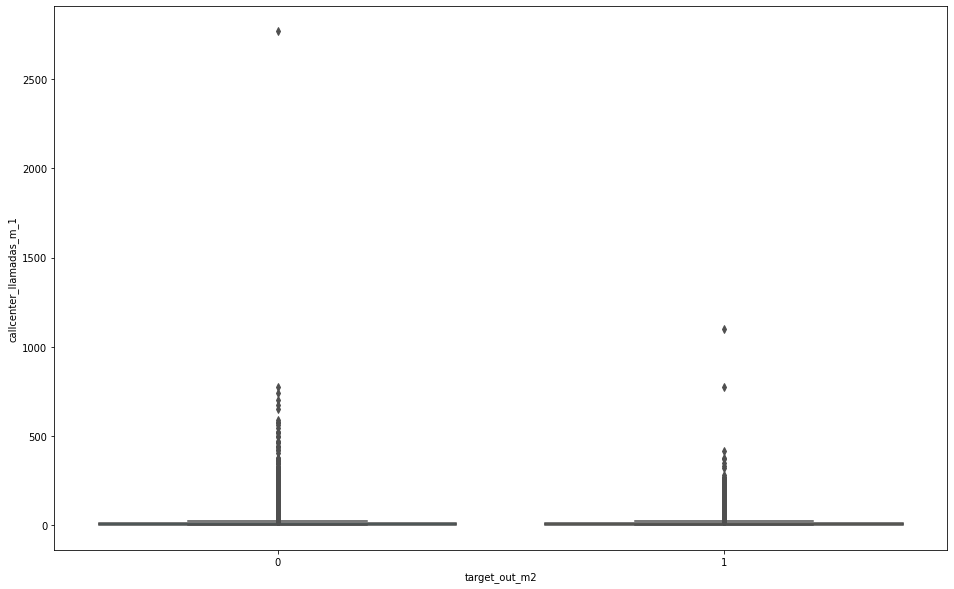

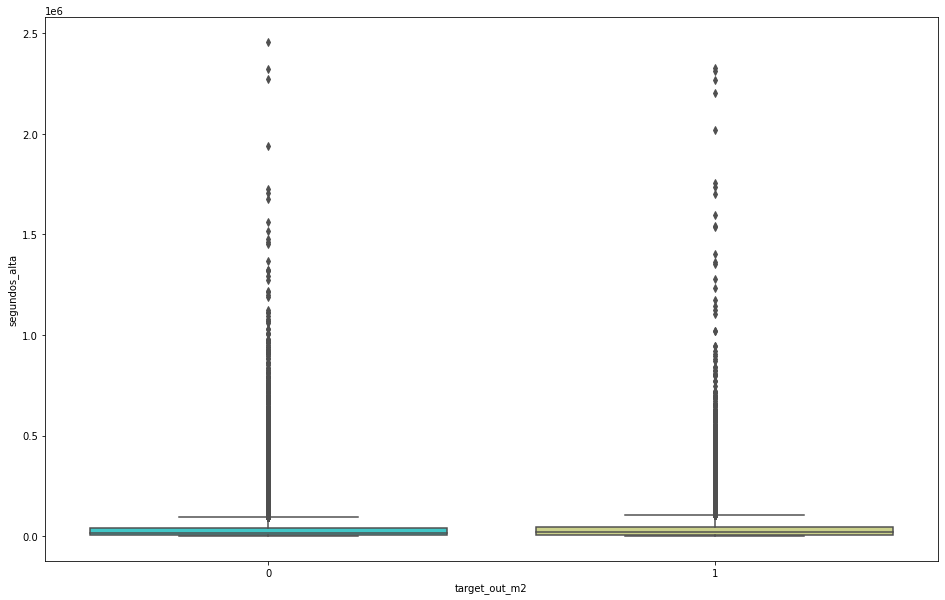

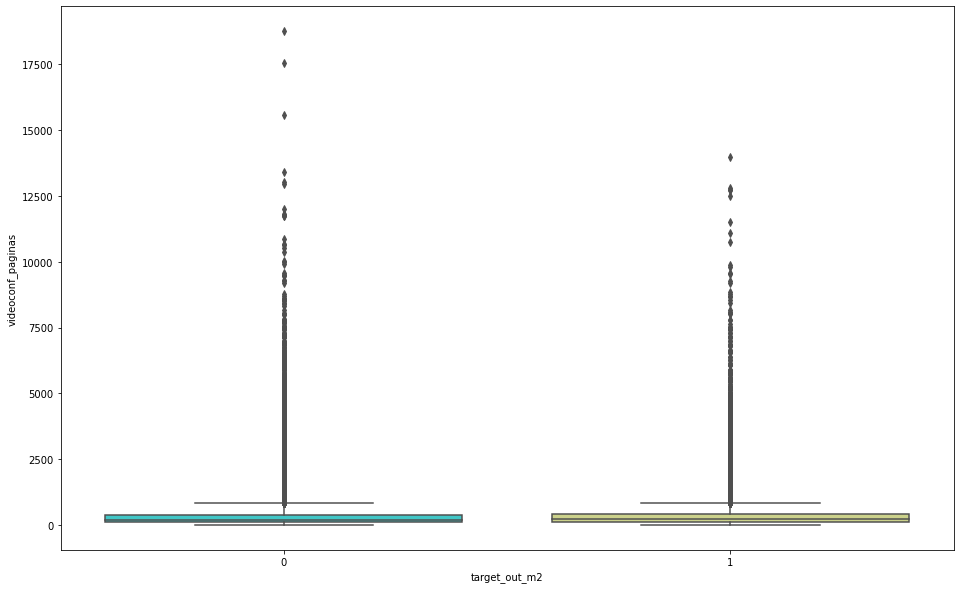

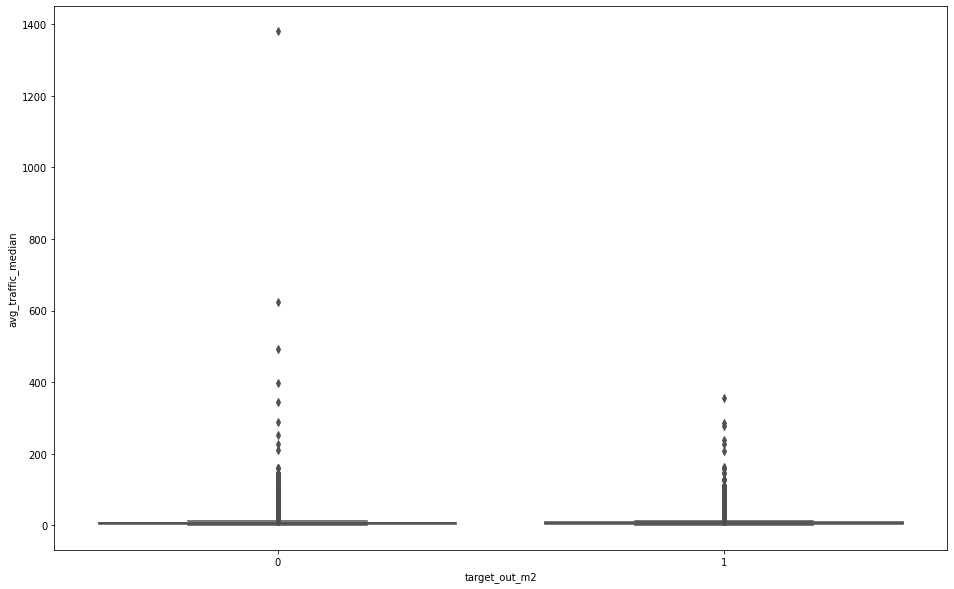

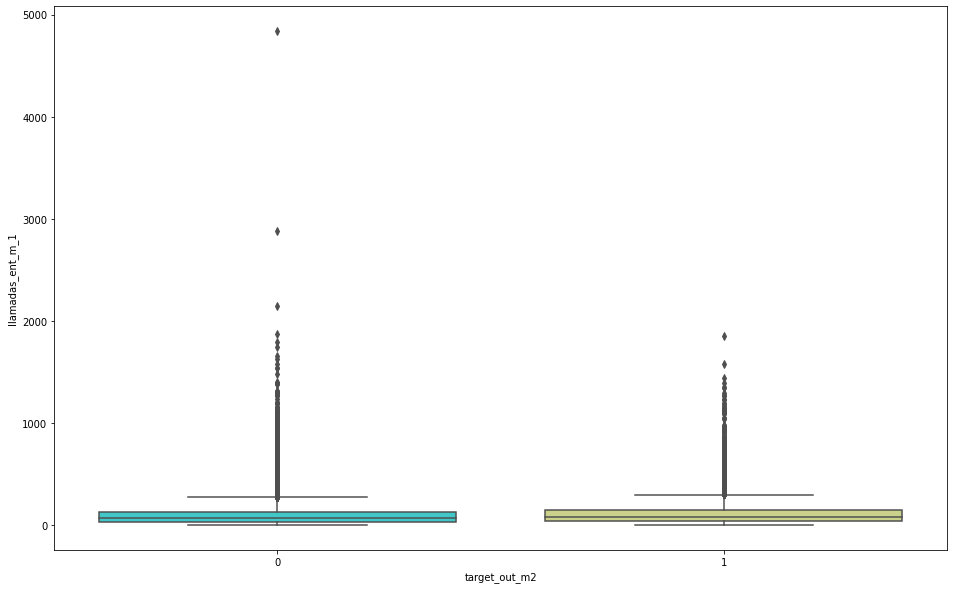

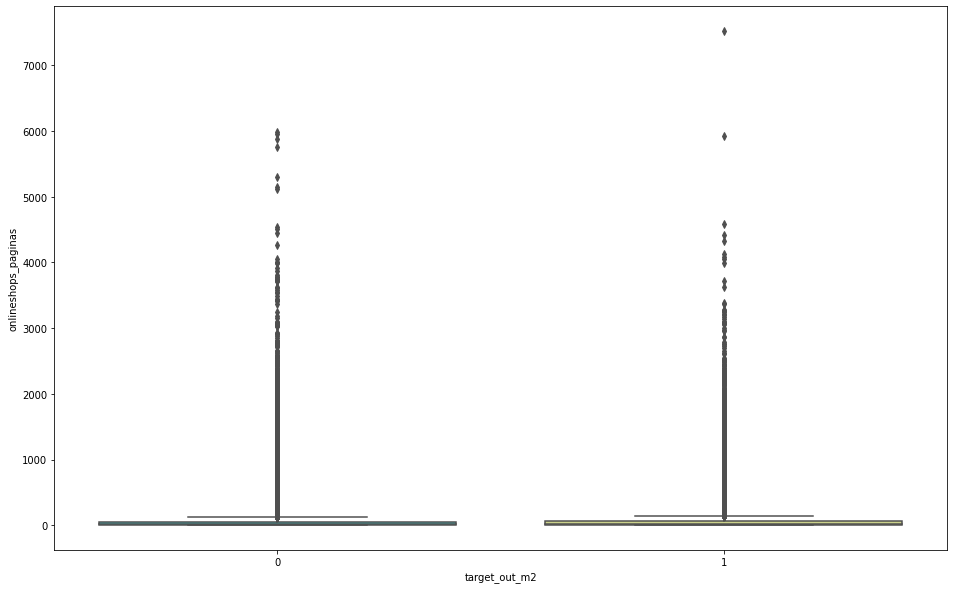

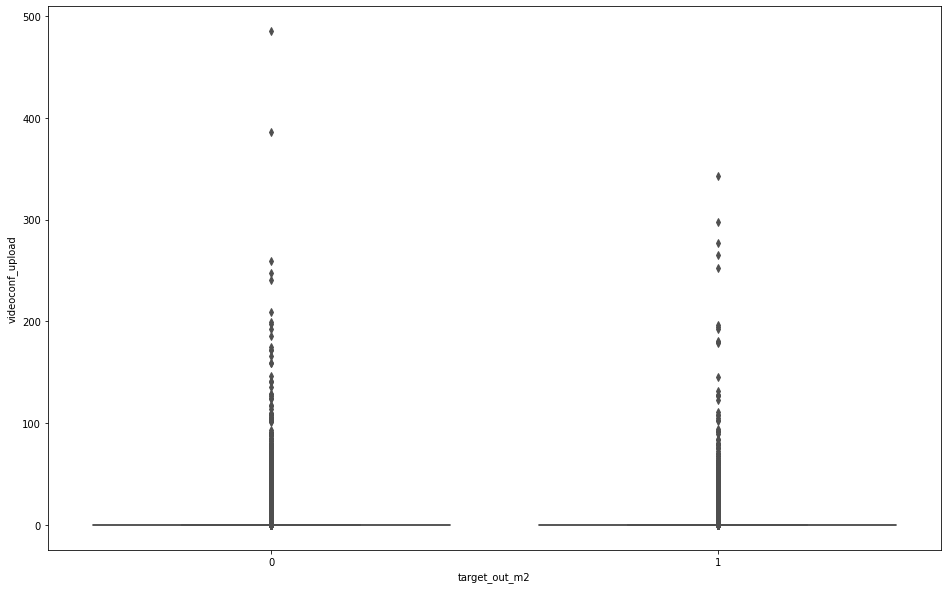

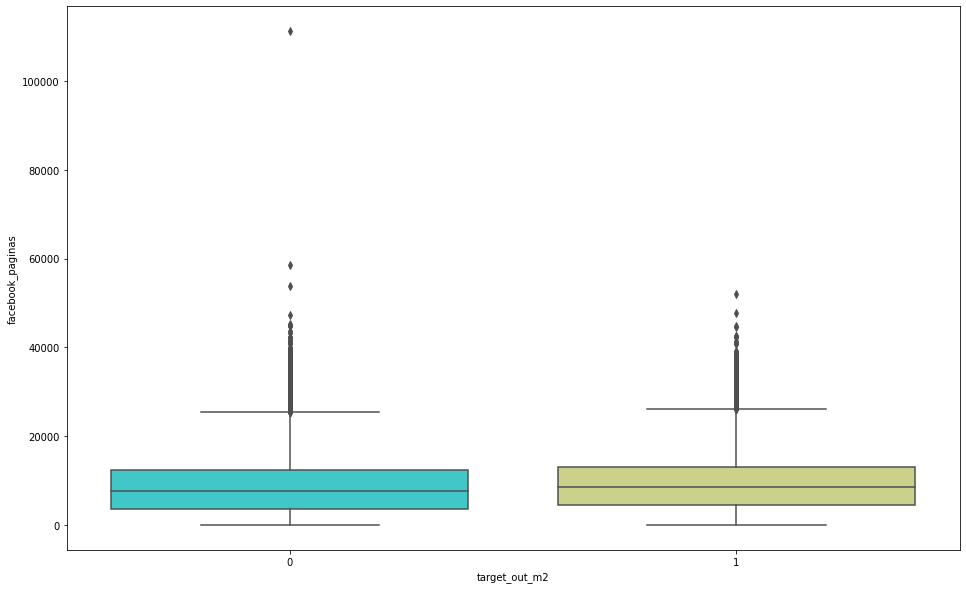

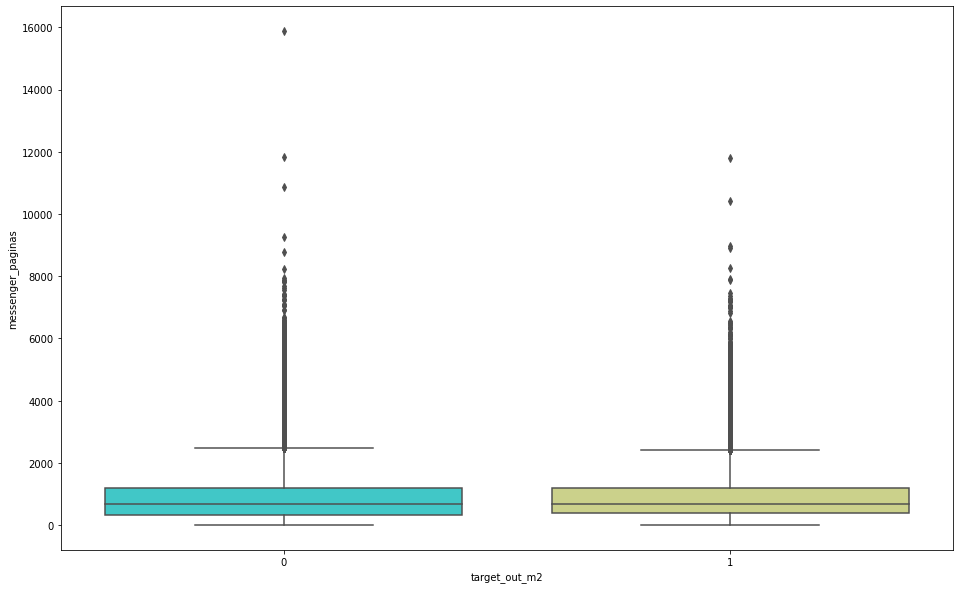

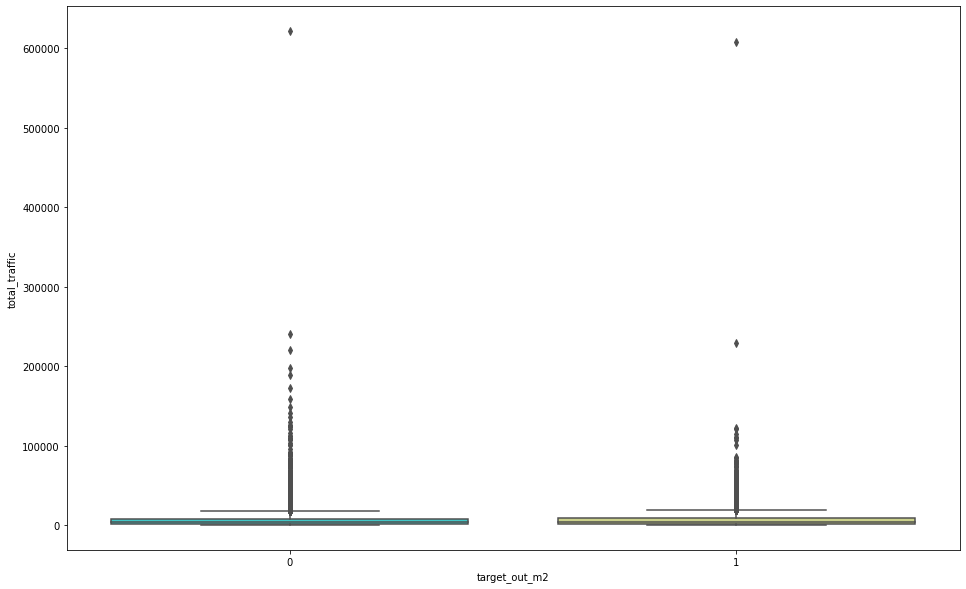

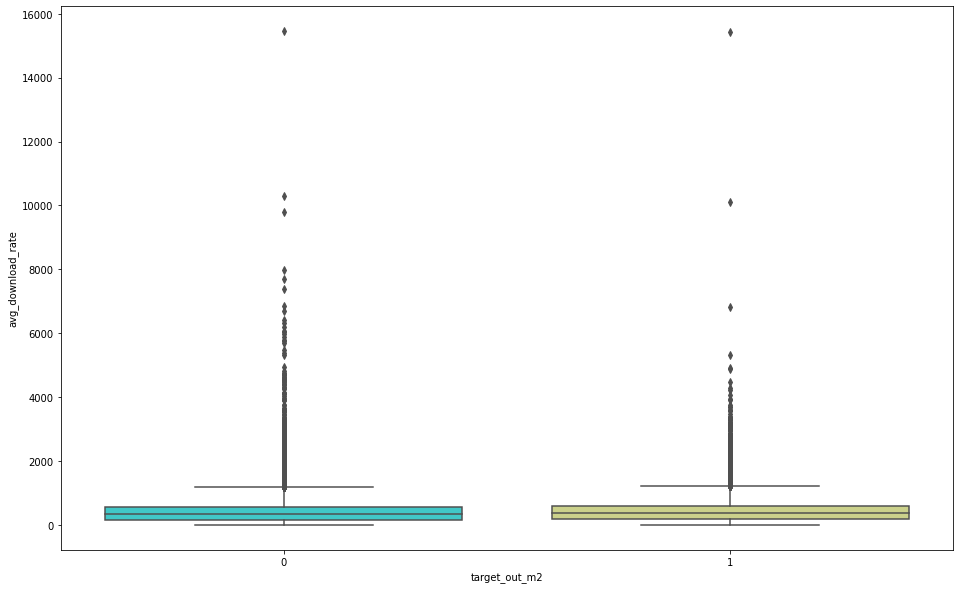

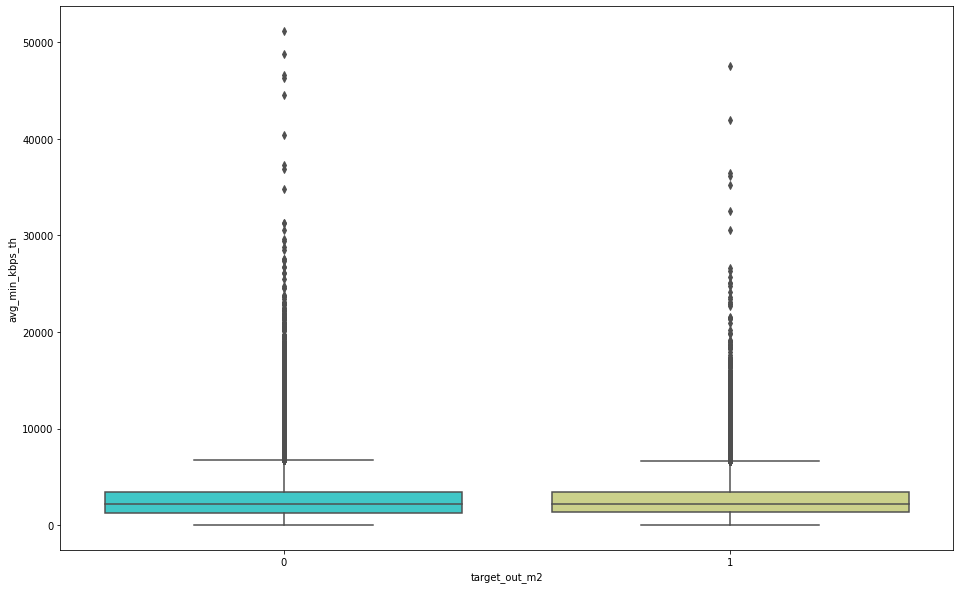

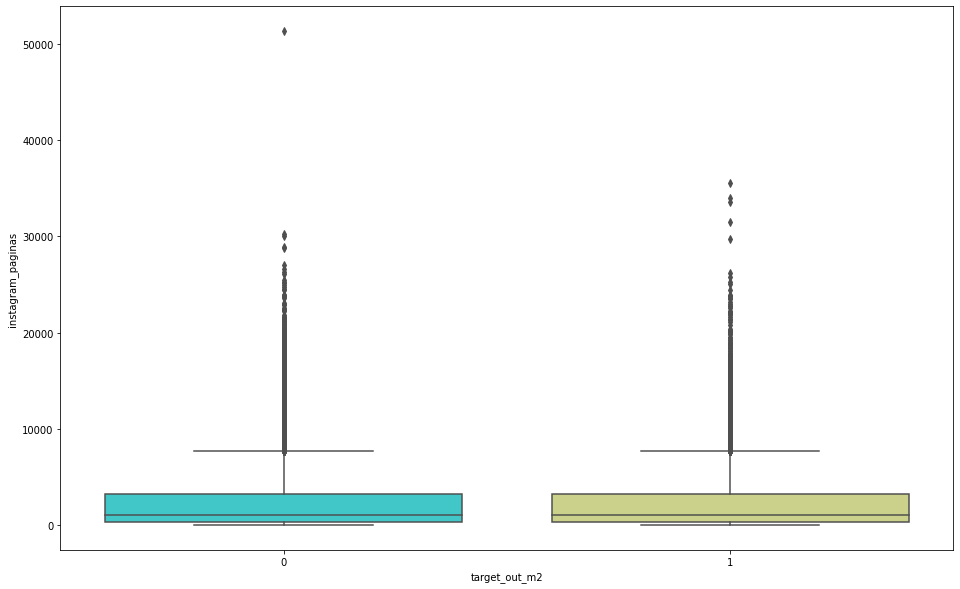

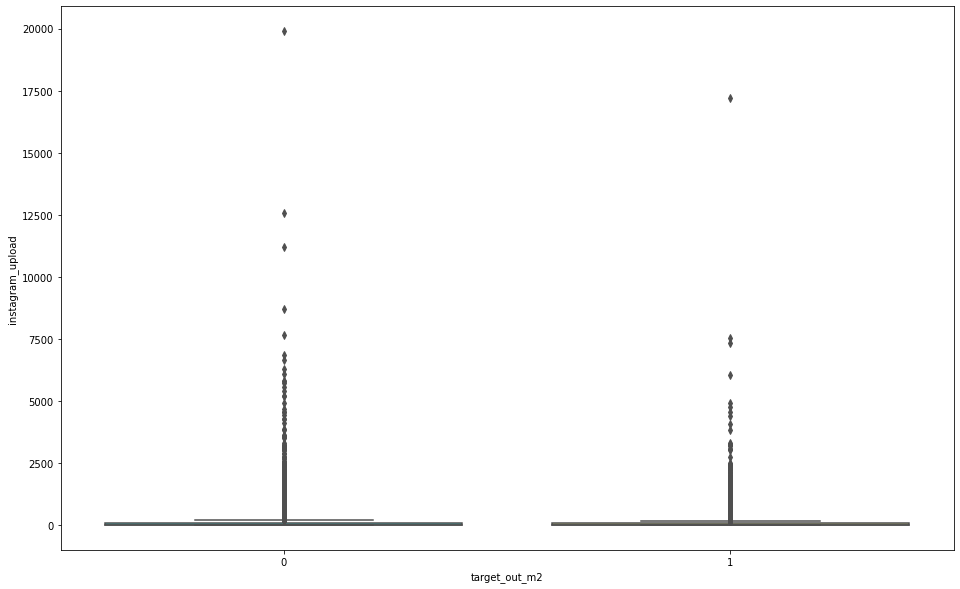

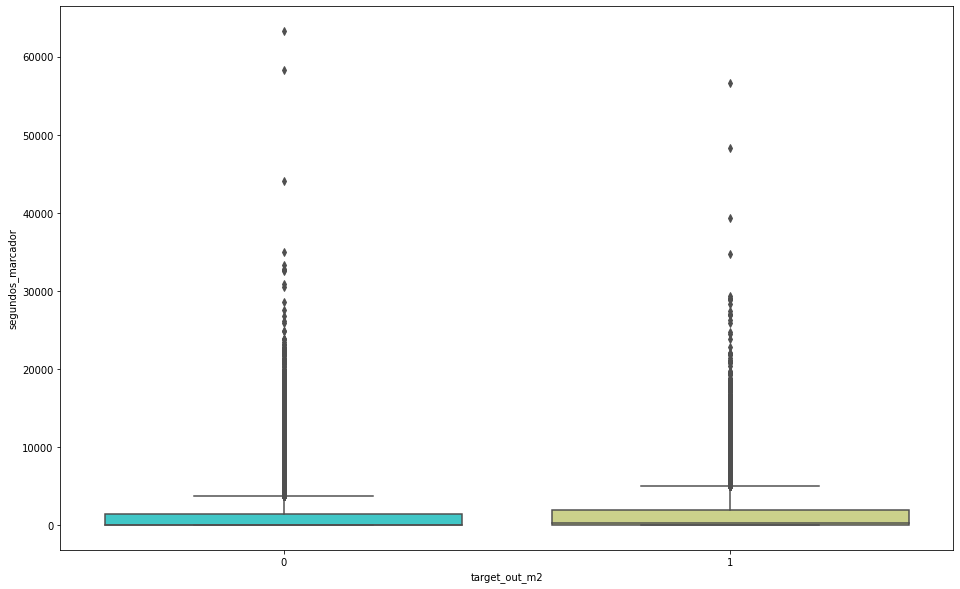

In [24]:
for var in numericas:
    plt.figure(figsize=(16,10))
    sns.boxplot(x='target_out_m2',y=var,data=df, palette='rainbow'#,
    #order=['Decil 1','Decil 2','Decil 3','Decil 4','Decil 5','Decil 6','Decil 7','Decil 8','Decil 9','Decil 10']
    )
    plt.show()

Por Decil

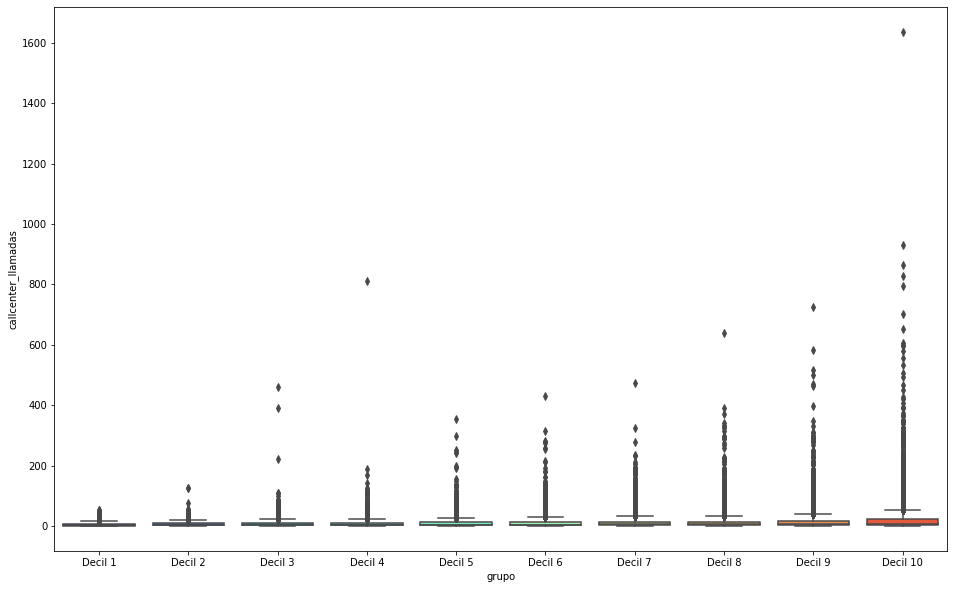

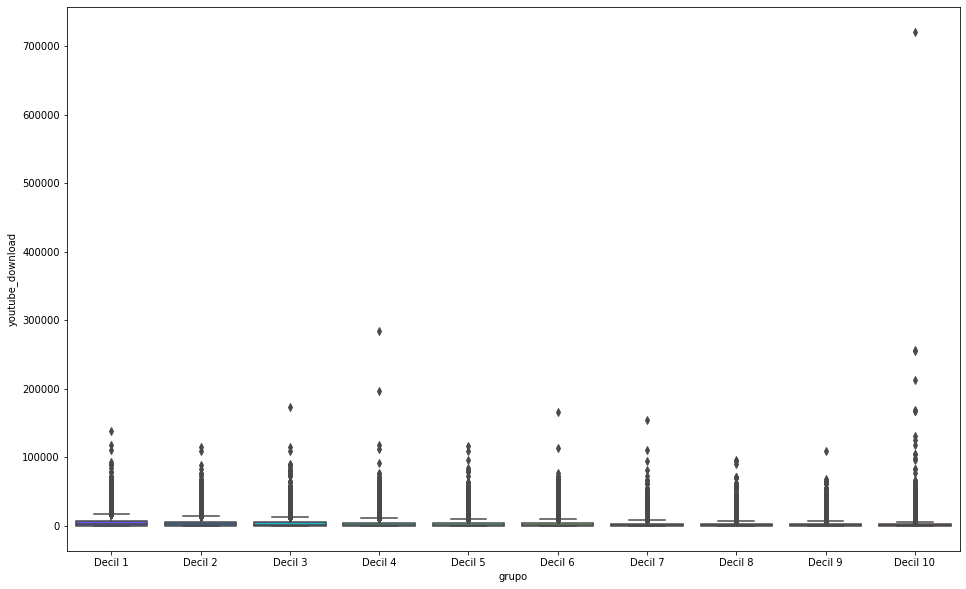

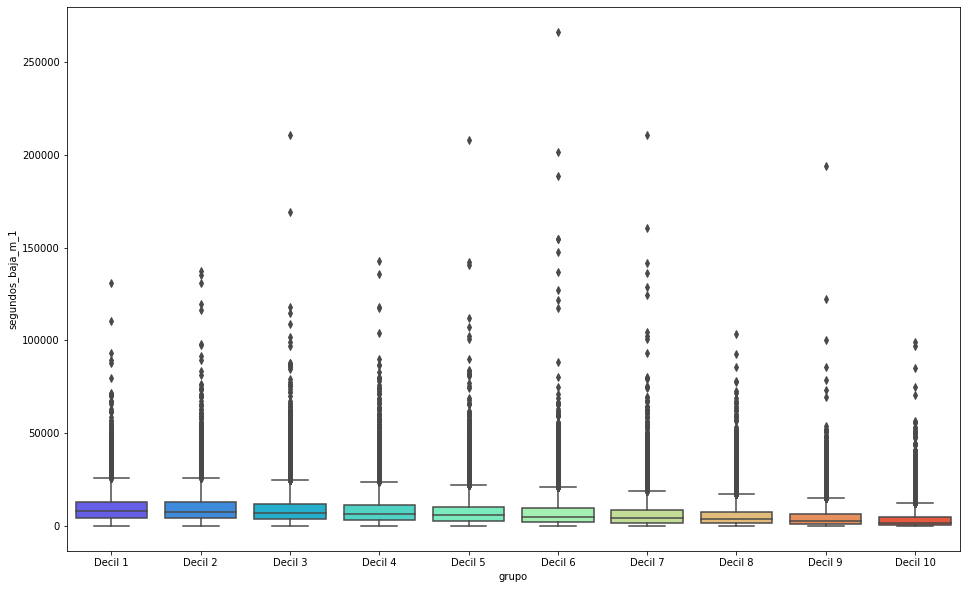

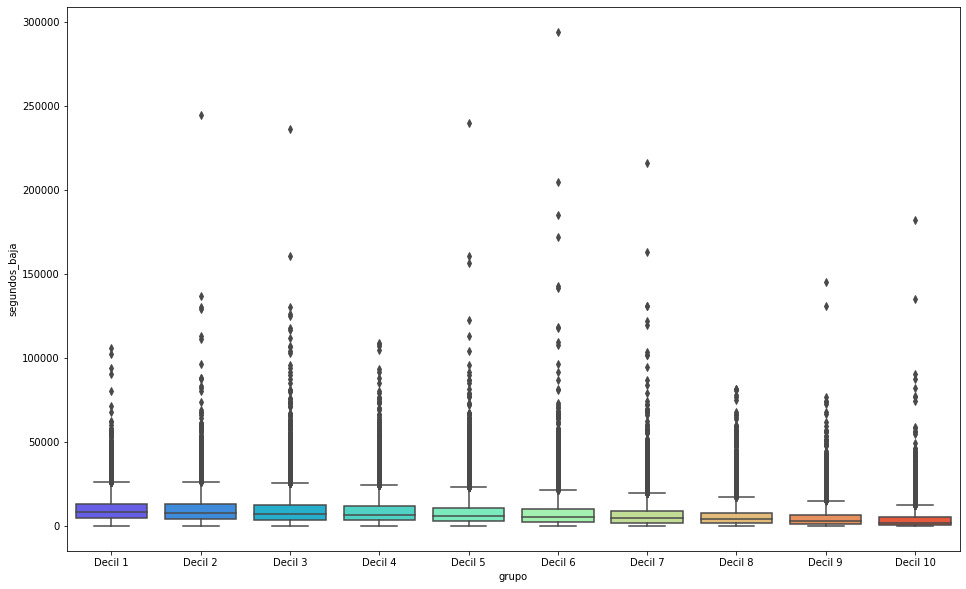

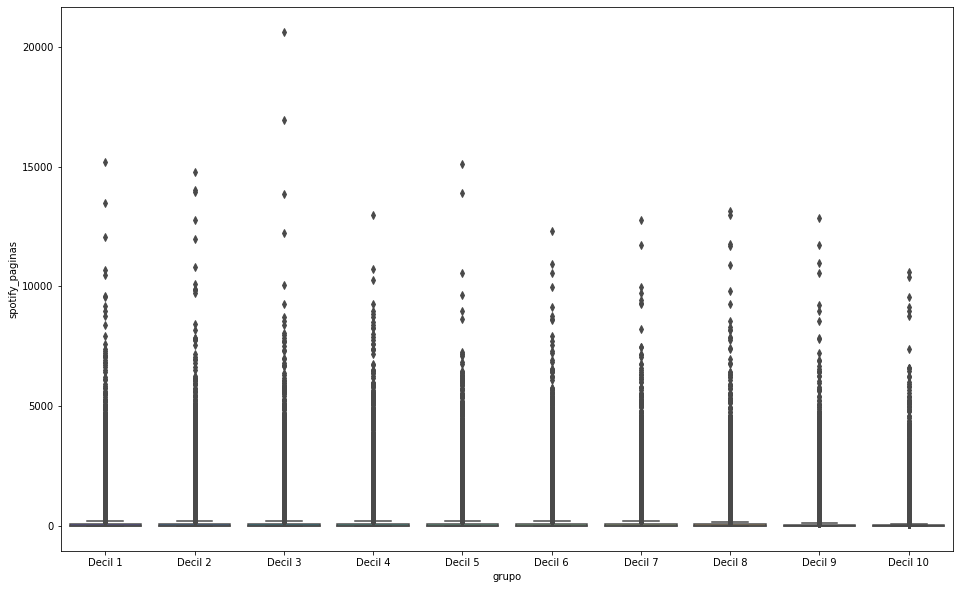

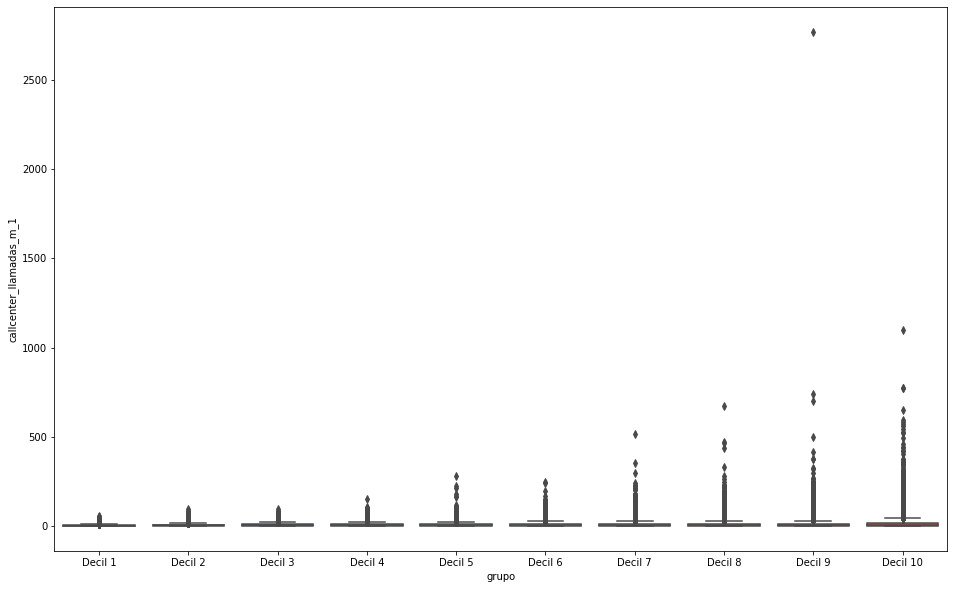

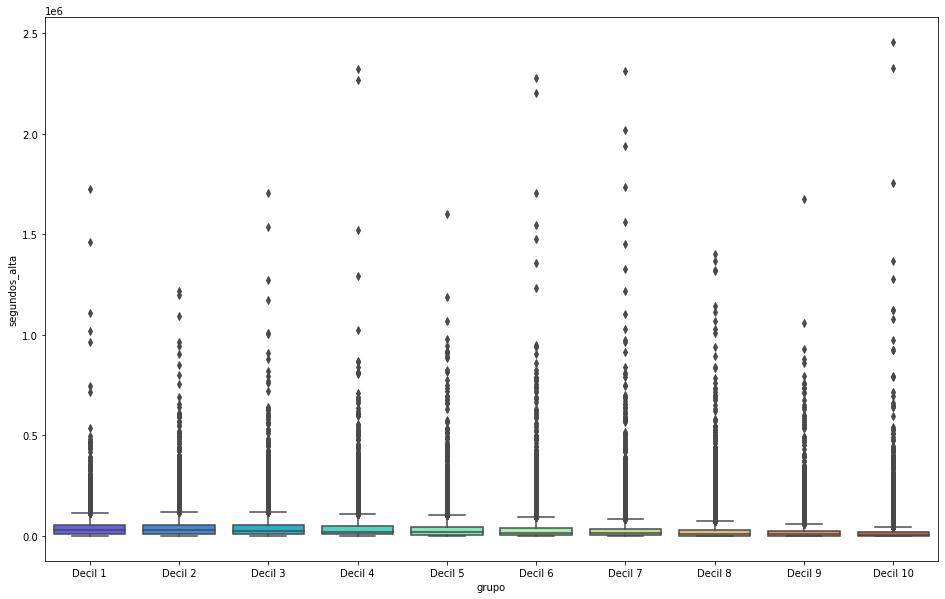

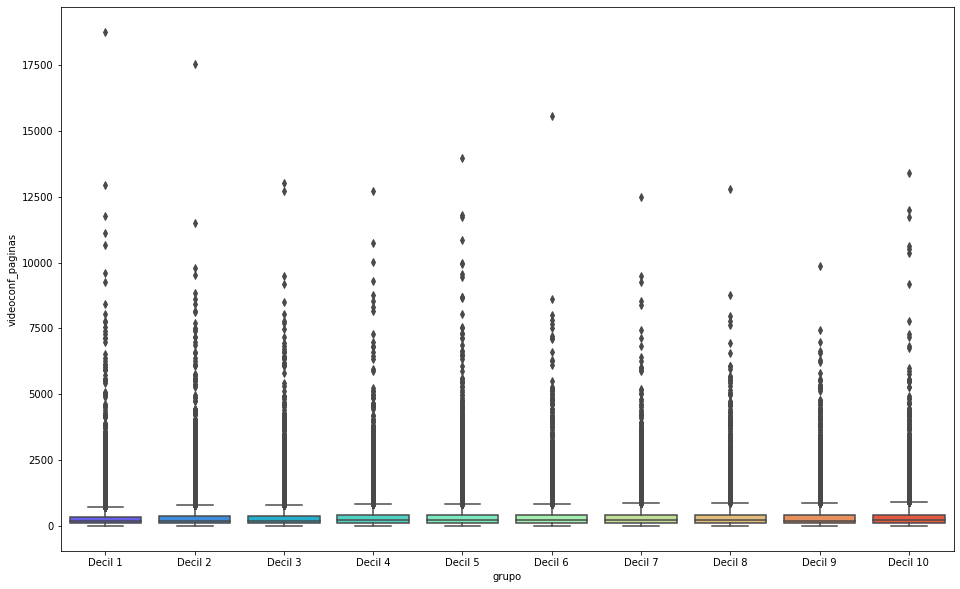

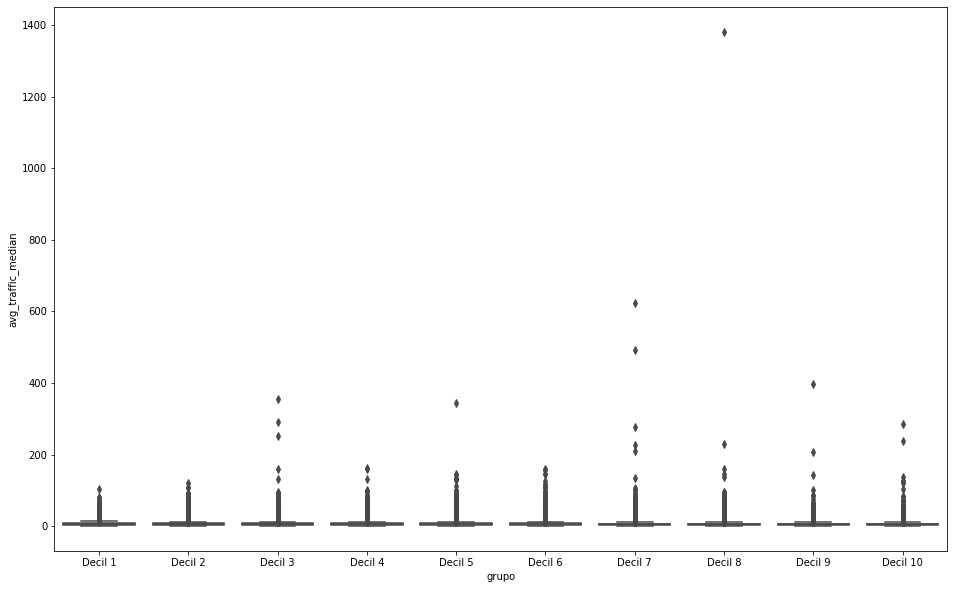

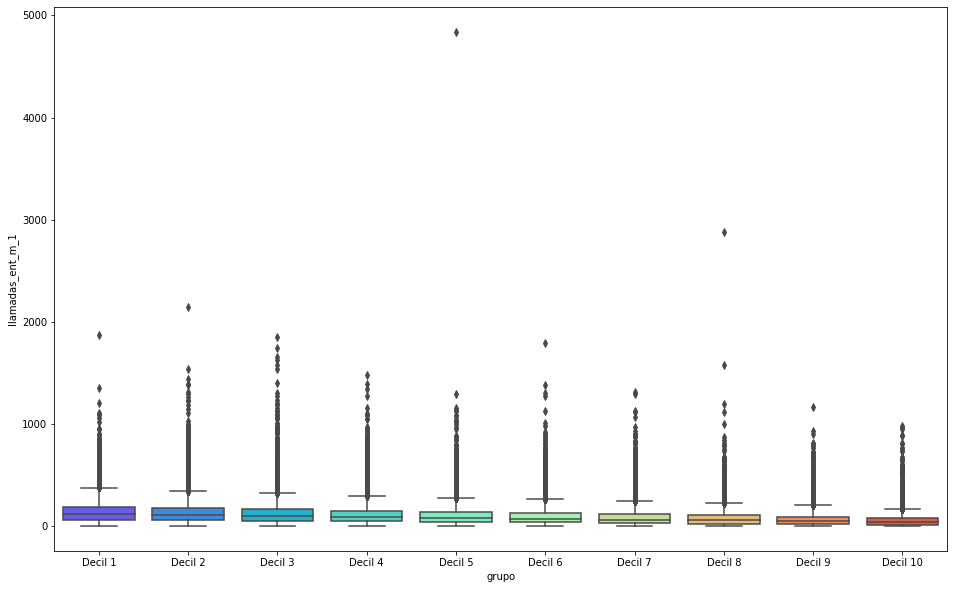

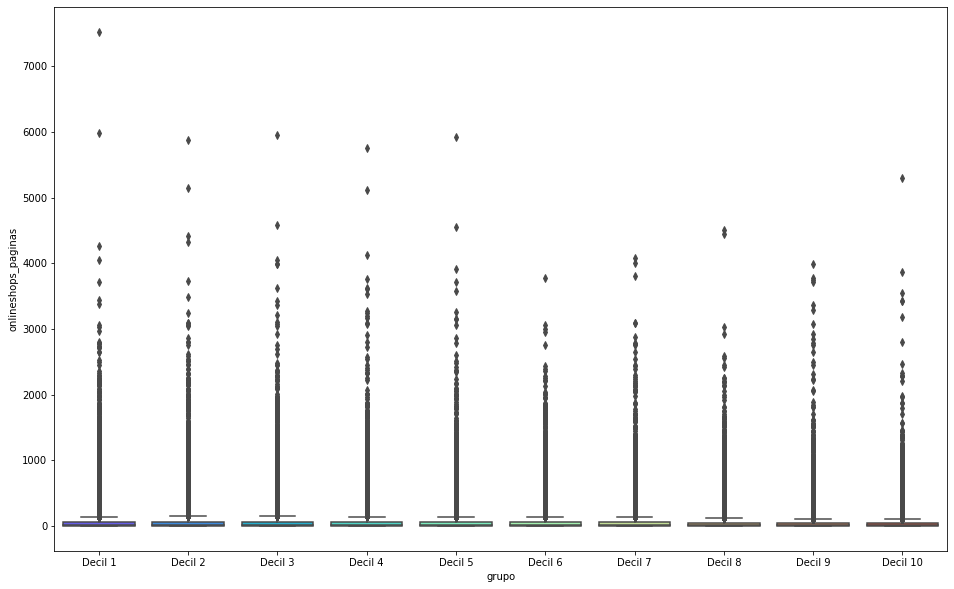

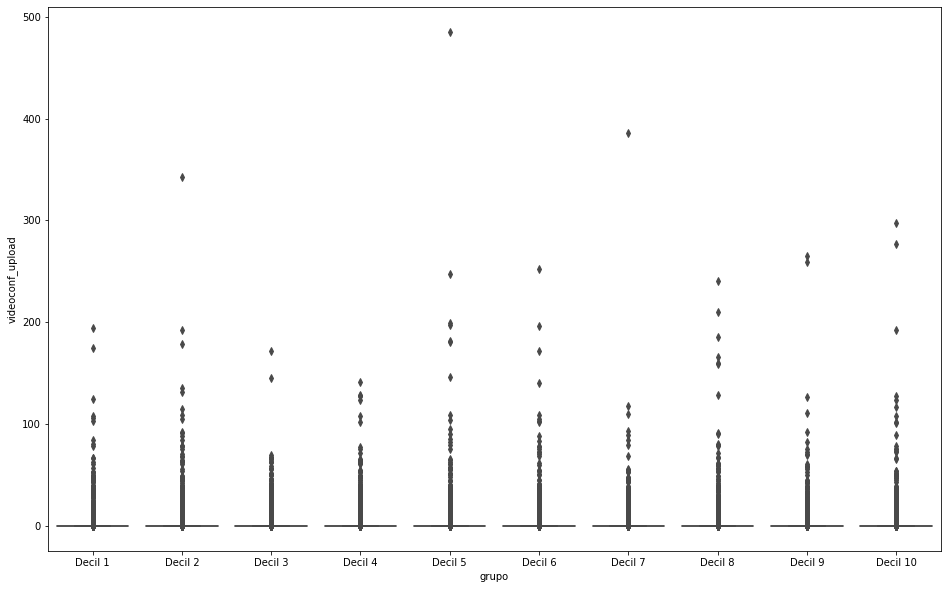

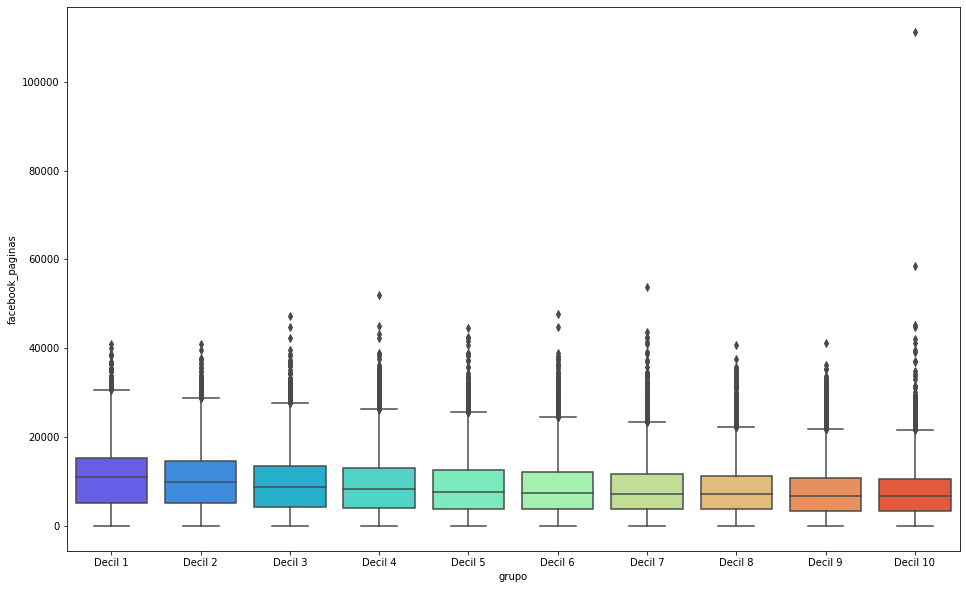

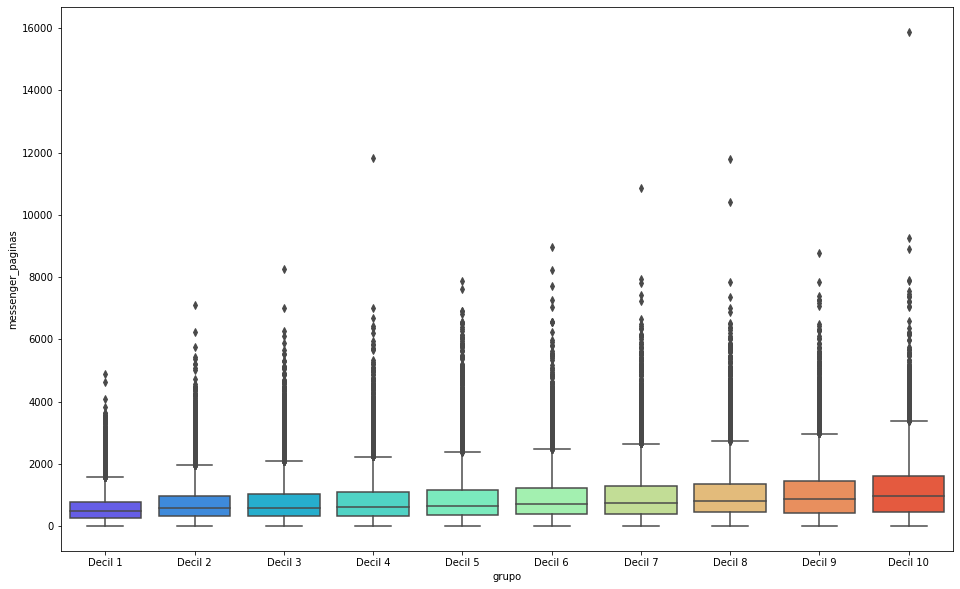

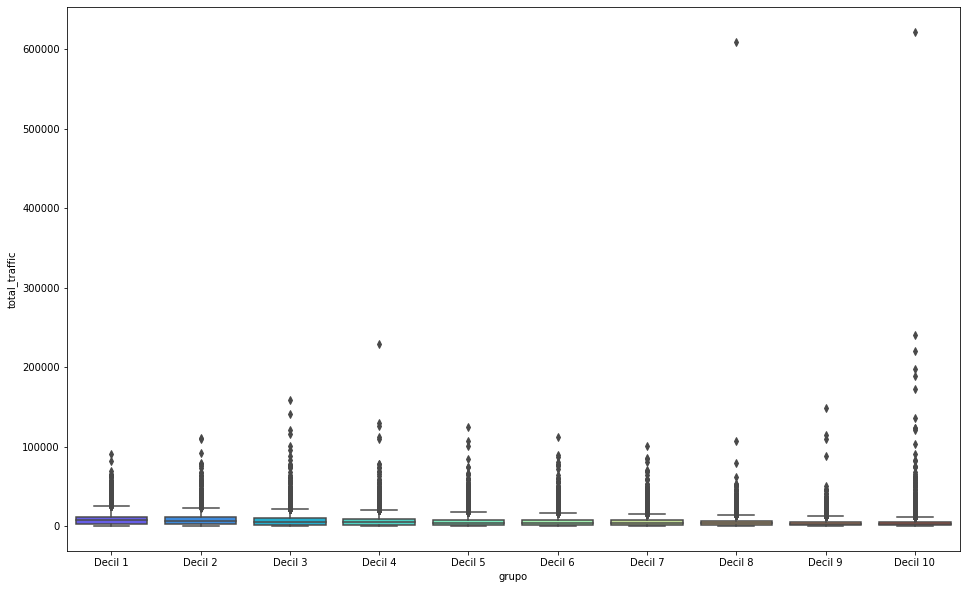

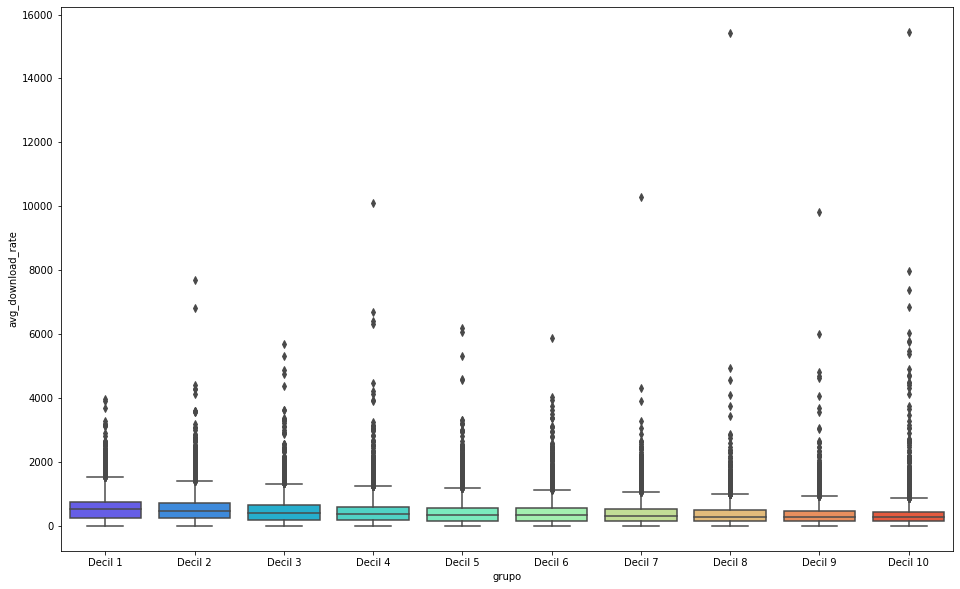

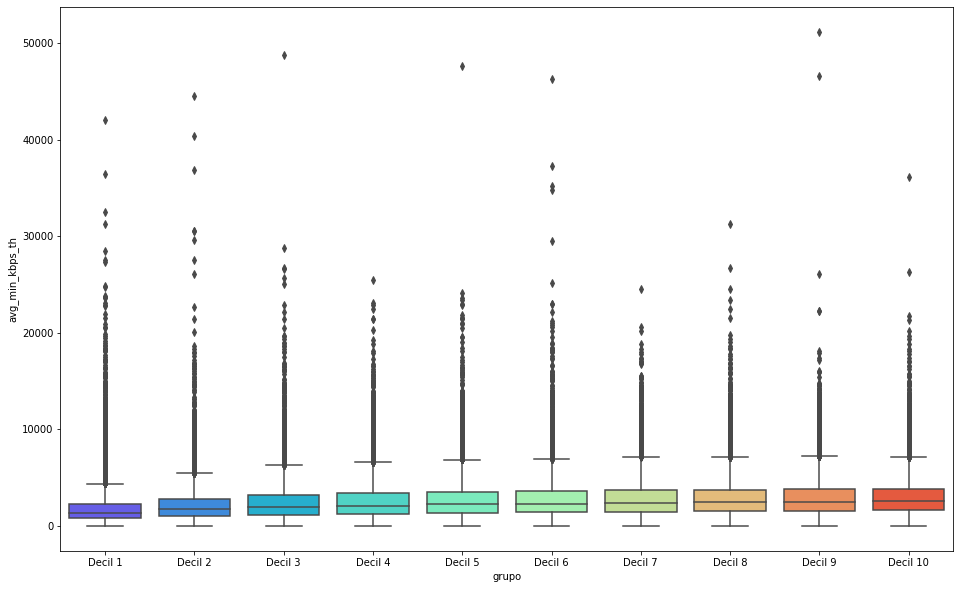

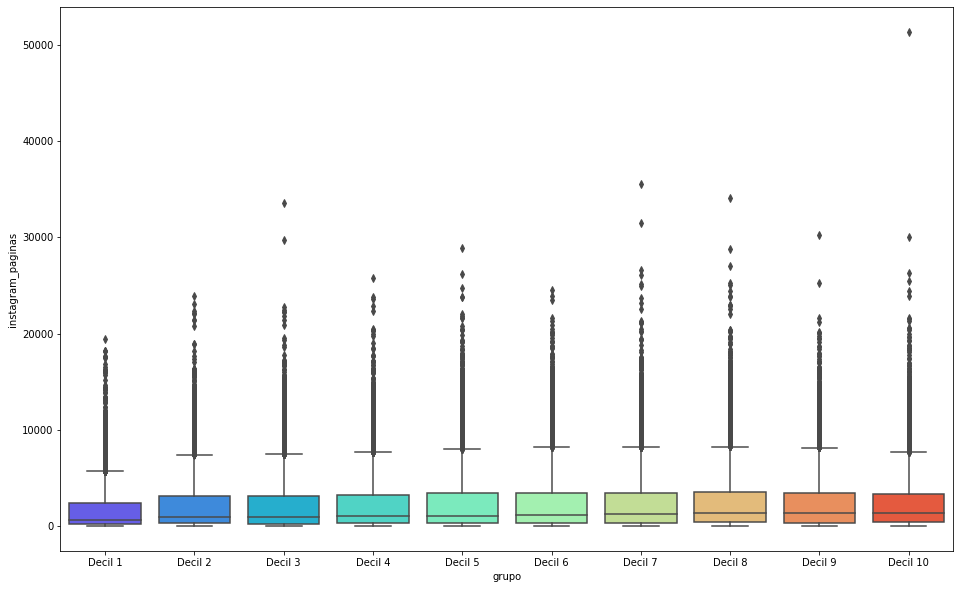

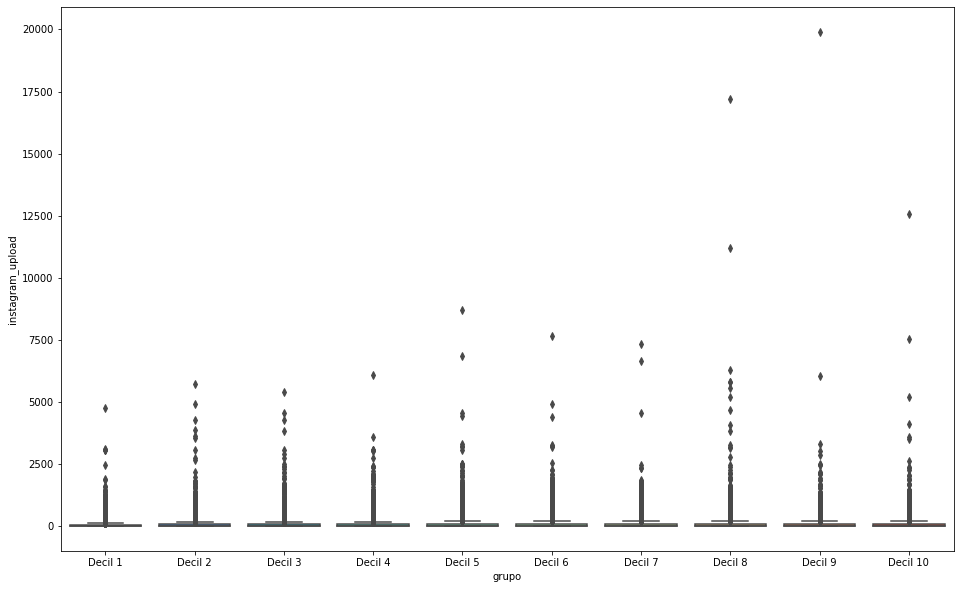

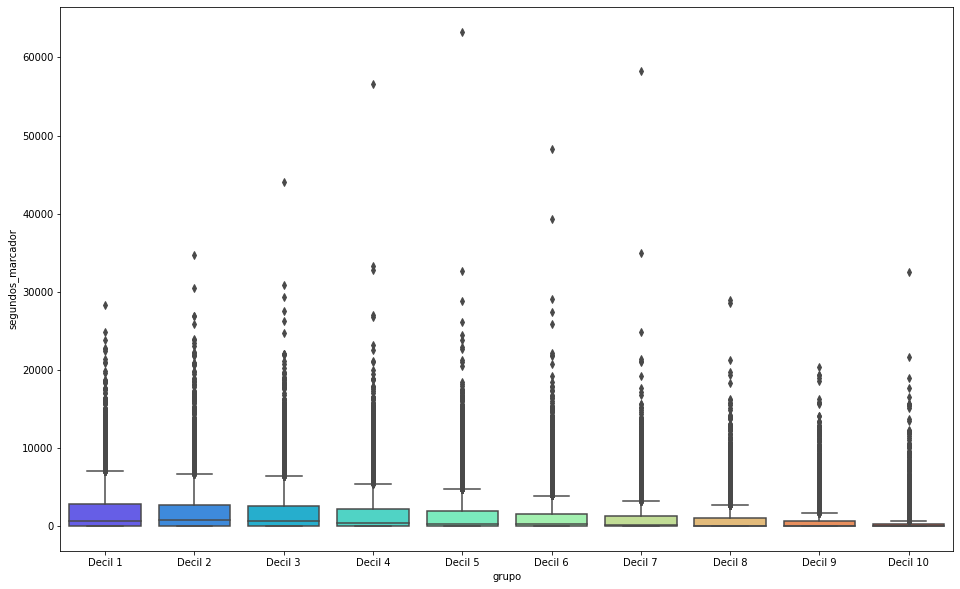

In [25]:
for var in numericas:
    plt.figure(figsize=(16,10))
    sns.boxplot(x='grupo',y=var,data=df, palette='rainbow',
    order=['Decil 1','Decil 2','Decil 3','Decil 4','Decil 5','Decil 6','Decil 7','Decil 8','Decil 9','Decil 10']
    )
    plt.show()

## Promedio

In [26]:
resumen=pd.DataFrame()
targets = [0,1]
for var in numericas:
    r_mesactual_grupo = pd.DataFrame(group.describe().rename(columns={var:decil}).iloc[:,0].squeeze()
                            for decil, group in df.loc[:, [var,'target_out_m2']].groupby('target_out_m2'))
    r_mesactual_grupo = r_mesactual_grupo.append(df[var].describe(include='all'))
    r_mesactual_grupo = r_mesactual_grupo.rename(index={var: 'total'})
    r_mesactual_grupo.index.names = ['variables']
    #r_mesactual_grupo.reset_index(level=0, inplace=True)
    r_mesactual_grupo = r_mesactual_grupo.round(2)
    r_mesactual_grupo.rename(columns={'mean':var},inplace=True)
    resumen=resumen.append(np.round(r_mesactual_grupo.loc[targets,var],2).T)

#resumen.to_csv('/home/userbda/Documents/Modelos/modelo_contactabilidad_Outbound/outputs/resumen_var/resumen_v2.csv')
resumen

,0,1
callcenter_llamadas,10.77,9.85
youtube_download,3744.31,3848.70
segundos_baja_m_1,7038.43,8179.40
segundos_baja,7261.05,8394.04
spotify_paginas,246.55,240.35
callcenter_llamadas_m_1,9.13,8.37
segundos_alta,33635.03,37677.16
videoconf_paginas,356.90,371.90
avg_traffic_median,6.44,6.71
llamadas_ent_m_1,96.68,111.67


In [29]:
pd.set_option('display.max_columns', None)
resumen=pd.DataFrame()
deciles=['Decil 1','Decil 2','Decil 3','Decil 4','Decil 5','Decil 6','Decil 7','Decil 8','Decil 9','Decil 10','total']
for var in numericas:
    r_mesactual_grupo = pd.DataFrame(group.describe().rename(columns={var:decil}).squeeze()
                            for decil, group in df.loc[:, [var,'grupo']].groupby('grupo'))
    r_mesactual_grupo = r_mesactual_grupo.append(df[var].describe(include='all'))
    r_mesactual_grupo = r_mesactual_grupo.rename(index={var: 'total'})
    r_mesactual_grupo.index.names = ['variables']
    #r_mesactual_grupo.reset_index(level=0, inplace=True)
    r_mesactual_grupo = r_mesactual_grupo.round(2)
    r_mesactual_grupo.rename(columns={'mean':var},inplace=True)
    resumen=resumen.append(np.round(r_mesactual_grupo.loc[deciles,var],2).T)

resumen.to_csv('/home/userbda/Documents/Modelos/modelo_contactabilidad_Outbound/outputs/resumen_var/resumen_v8_traf_m2.csv')
resumen

,Decil 1,Decil 2,Decil 3,Decil 4,Decil 5,Decil 6,Decil 7,Decil 8,Decil 9,Decil 10,total
callcenter_llamadas,5.13,6.54,7.43,8.01,8.96,10.14,11.17,12.55,14.32,20.32,10.46
youtube_download,5591.46,4975.20,4427.56,4010.10,3741.30,3463.95,3207.17,2926.64,2629.26,2821.90,3779.46
segundos_baja_m_1,9749.70,9719.62,9288.55,8739.52,8047.00,7472.15,6653.62,5888.13,4882.89,3785.28,7422.64
segundos_baja,9862.78,9962.18,9657.40,8955.71,8353.51,7792.98,6949.75,6070.39,4935.23,3885.85,7642.57
spotify_paginas,234.29,259.23,253.33,253.62,263.56,260.31,259.58,245.03,217.51,198.18,244.47
callcenter_llamadas_m_1,4.65,5.80,6.34,6.66,7.38,8.29,9.23,10.34,12.17,17.89,8.87
segundos_alta,41232.44,44753.66,43201.89,40580.80,37978.41,35788.17,33461.42,29298.09,23869.01,19798.38,34996.16
videoconf_paginas,333.24,368.59,369.00,361.93,375.53,363.13,367.74,367.32,346.29,366.74,361.95
avg_traffic_median,6.80,6.83,6.80,6.72,6.66,6.54,6.50,6.39,5.89,6.16,6.53
llamadas_ent_m_1,142.55,136.48,126.66,114.57,104.83,97.53,88.55,79.53,69.43,57.20,101.73


In [30]:
pd.set_option('display.max_columns', None)
resumen2=pd.DataFrame()
deciles=['Decil 1','Decil 2','Decil 3','Decil 4','Decil 5','Decil 6','Decil 7','Decil 8','Decil 9','Decil 10','total']
df_2 =df.loc[df['target_out_m2']==1, :]
for var in numericas:
    r_mesactual_grupo = pd.DataFrame(group.describe().rename(columns={var:decil}).squeeze()
                            for decil, group in df_2.loc[:, [var,'grupo']].groupby('grupo'))
    r_mesactual_grupo = r_mesactual_grupo.append(df_2[var].describe(include='all'))
    r_mesactual_grupo = r_mesactual_grupo.rename(index={var: 'total'})
    r_mesactual_grupo.index.names = ['variables']
    #r_mesactual_grupo.reset_index(level=0, inplace=True)
    r_mesactual_grupo = r_mesactual_grupo.round(2)
    r_mesactual_grupo.rename(columns={'mean':var},inplace=True)
    resumen2=resumen2.append(np.round(r_mesactual_grupo.loc[deciles,var],2).T)

resumen2.to_csv('/home/userbda/Documents/Modelos/modelo_contactabilidad_Outbound/outputs/resumen_var/resumen_v8_traf_m2_1.csv')
resumen2

,Decil 1,Decil 2,Decil 3,Decil 4,Decil 5,Decil 6,Decil 7,Decil 8,Decil 9,Decil 10,total
callcenter_llamadas,5.34,6.65,7.39,8.28,8.95,10.48,11.76,12.22,14.87,18.01,9.85
youtube_download,5735.04,4945.16,4277.89,3885.56,3660.19,3506.03,3208.83,2871.56,2744.15,2369.60,3848.70
segundos_baja_m_1,10206.00,10162.79,9734.96,9159.11,8221.95,7858.76,7181.75,6256.94,5655.89,4679.91,8179.40
segundos_baja,10242.09,10381.01,10184.97,9339.58,8615.14,8101.11,7459.00,6417.29,5747.91,4661.52,8394.04
spotify_paginas,246.18,263.16,246.66,247.97,256.50,253.35,253.19,221.60,208.12,170.12,240.35
callcenter_llamadas_m_1,4.81,5.89,6.37,6.85,7.34,8.48,9.37,10.19,13.20,16.13,8.37
segundos_alta,41800.69,45591.20,44212.89,41059.75,39989.43,36298.00,35094.52,30695.26,26705.55,25639.06,37677.16
videoconf_paginas,338.87,375.05,367.37,366.52,376.00,368.54,378.42,384.51,383.54,397.16,371.90
avg_traffic_median,7.06,6.96,6.87,6.71,6.82,6.68,6.53,6.33,6.19,6.73,6.71
llamadas_ent_m_1,148.52,141.43,131.64,121.65,109.32,101.17,94.87,84.37,79.00,68.78,111.67


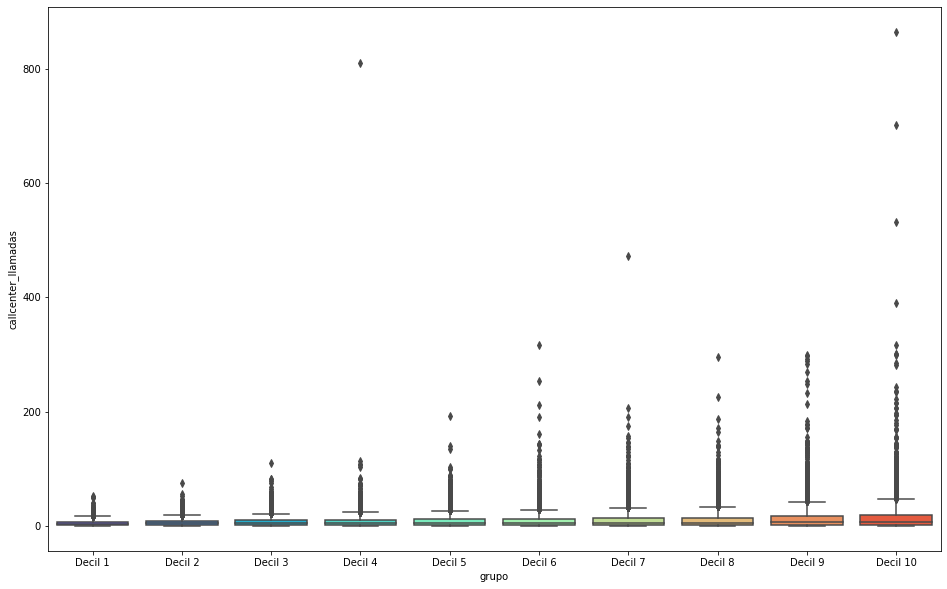

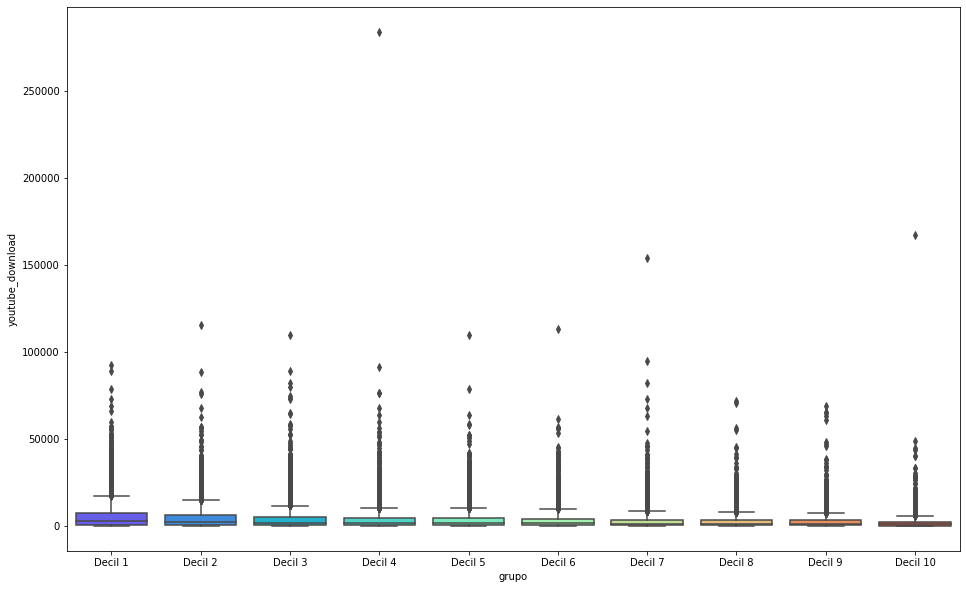

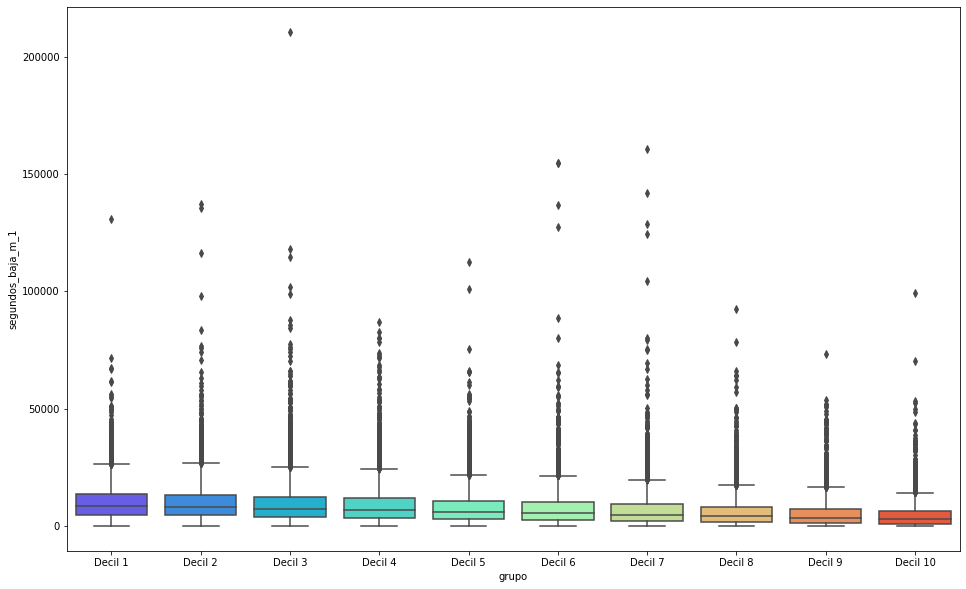

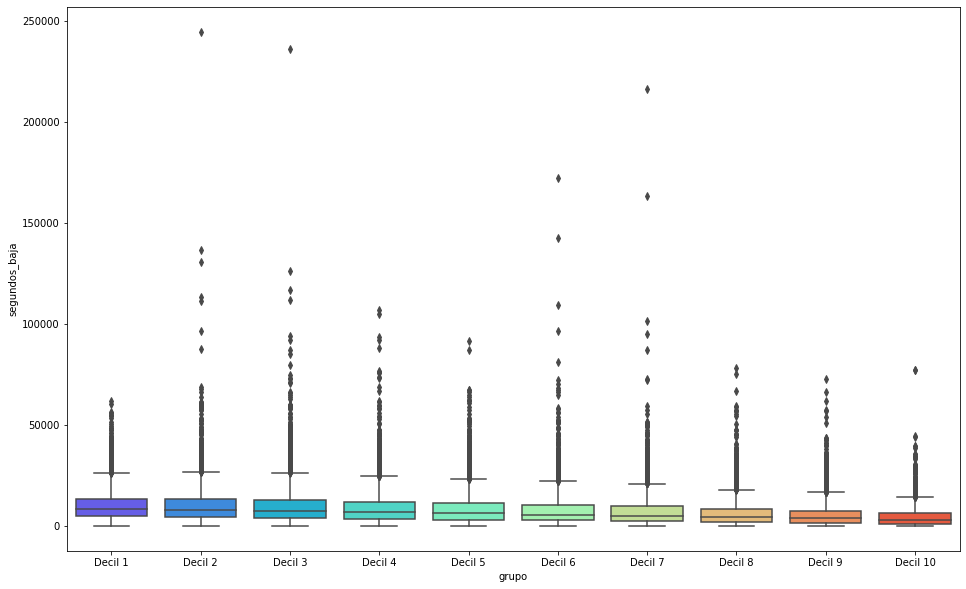

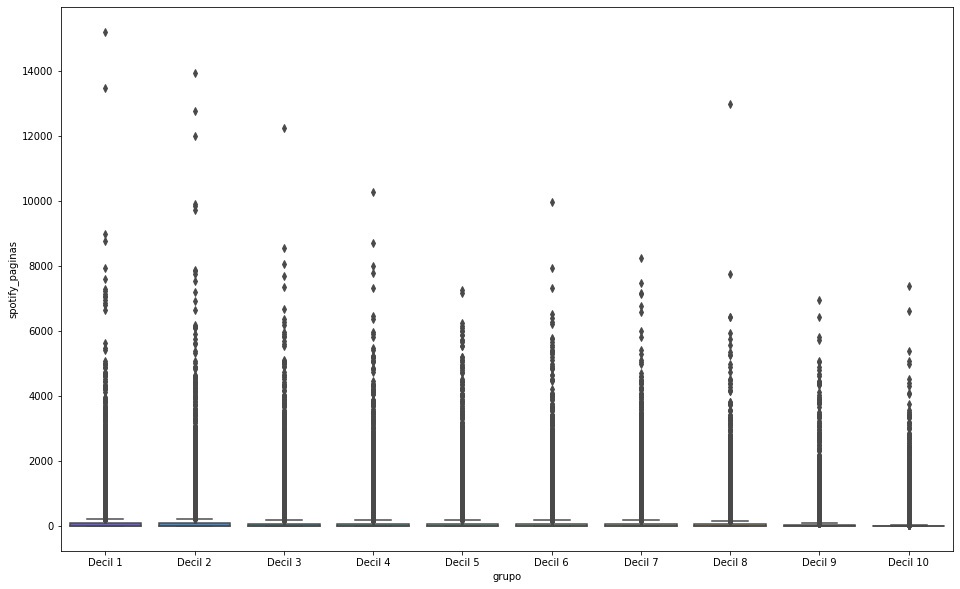

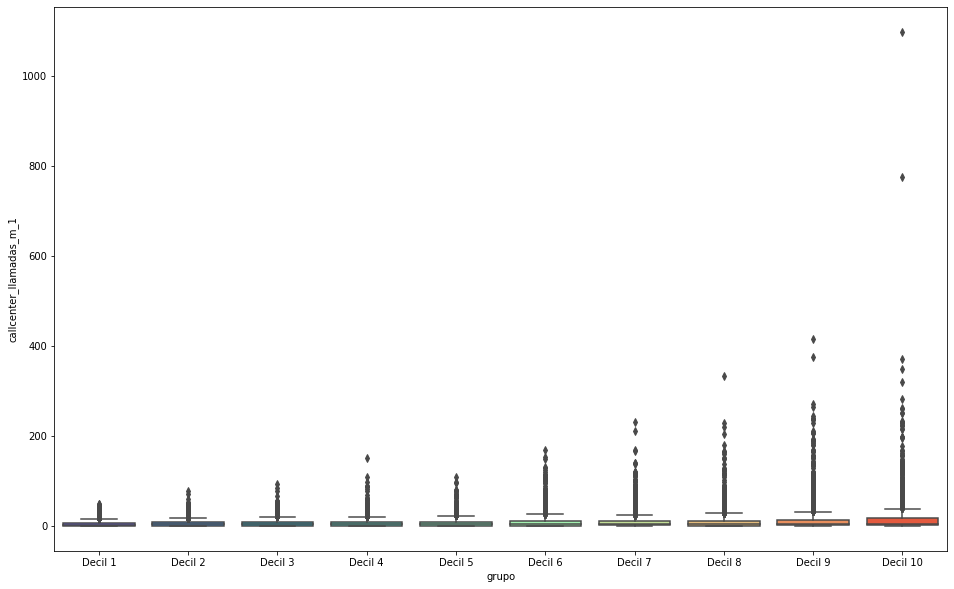

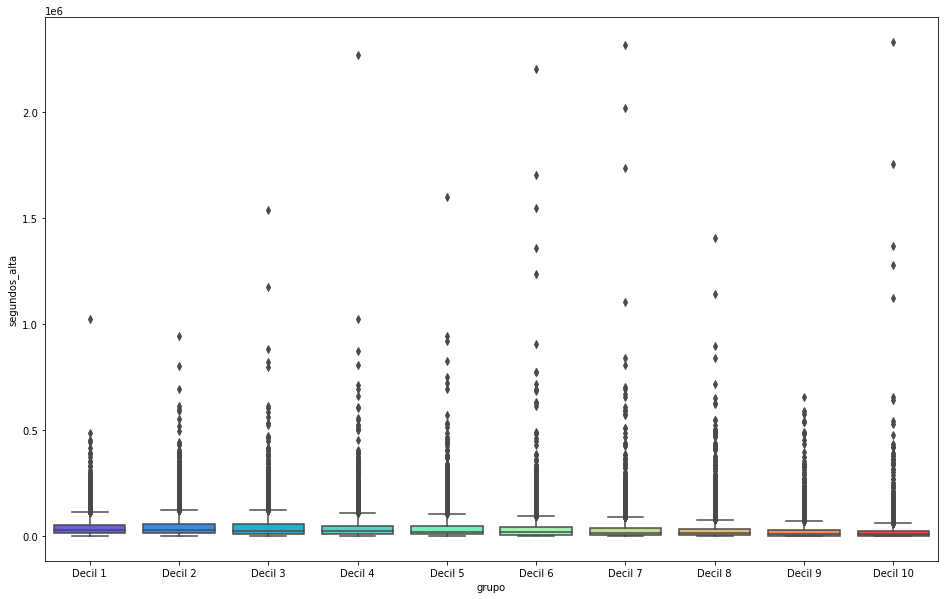

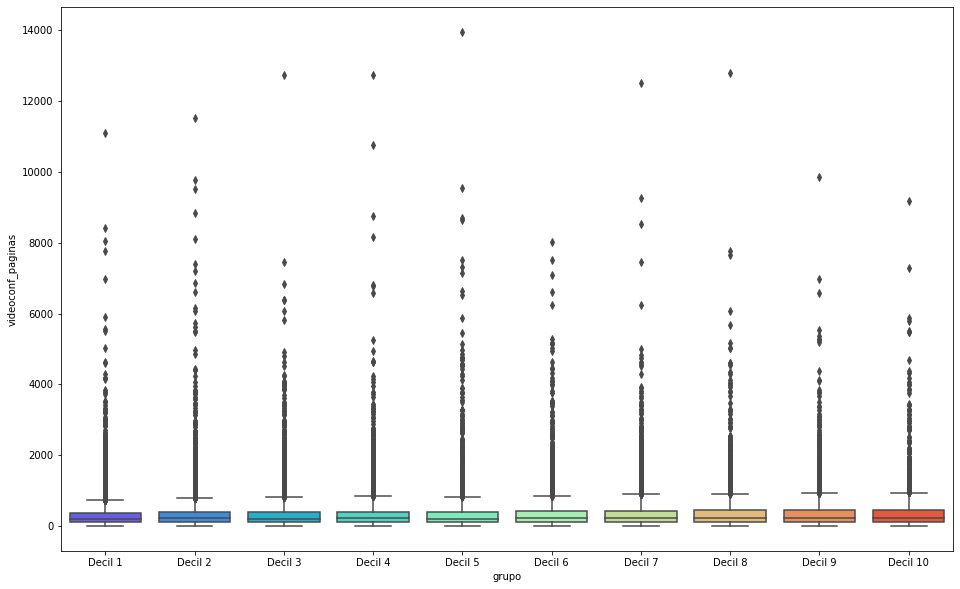

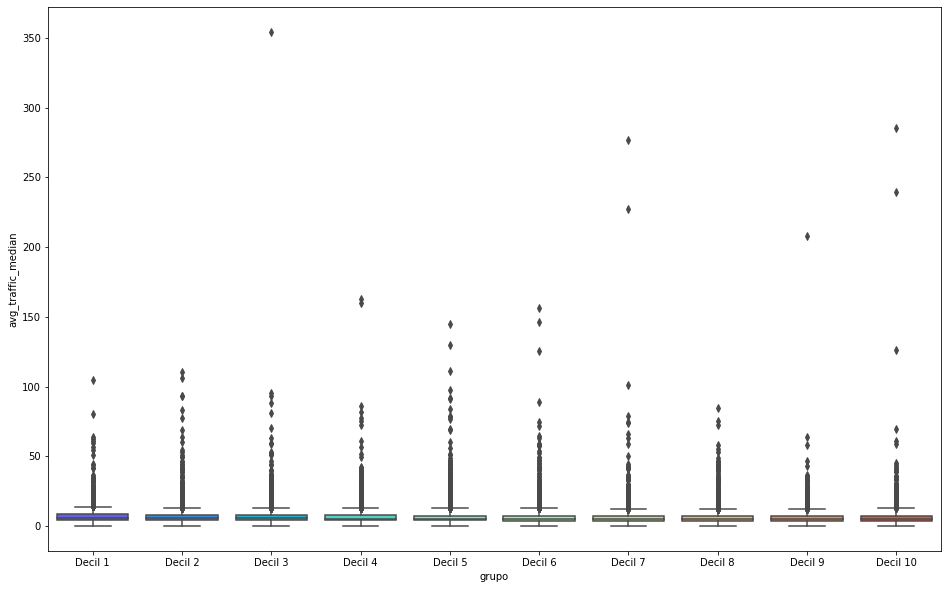

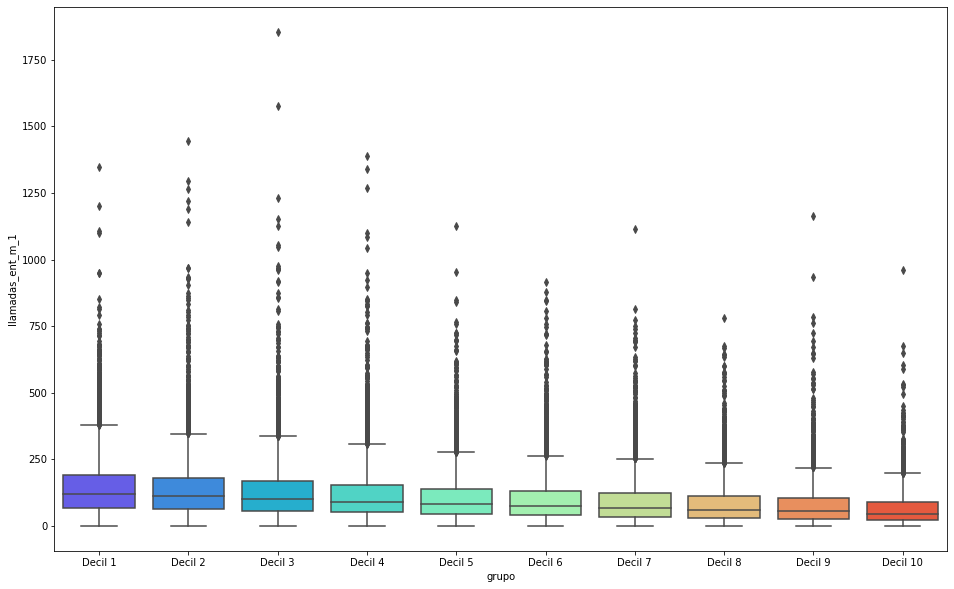

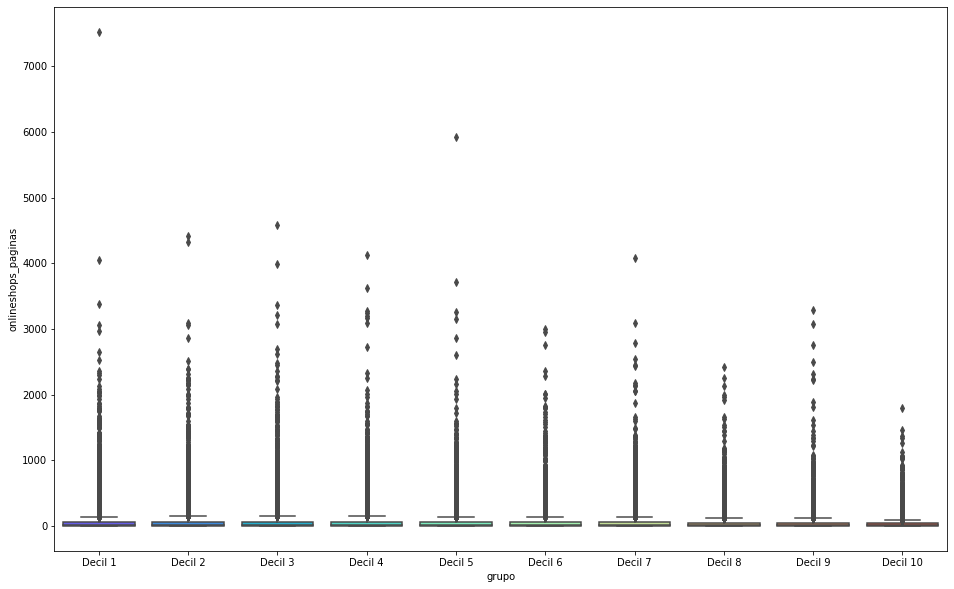

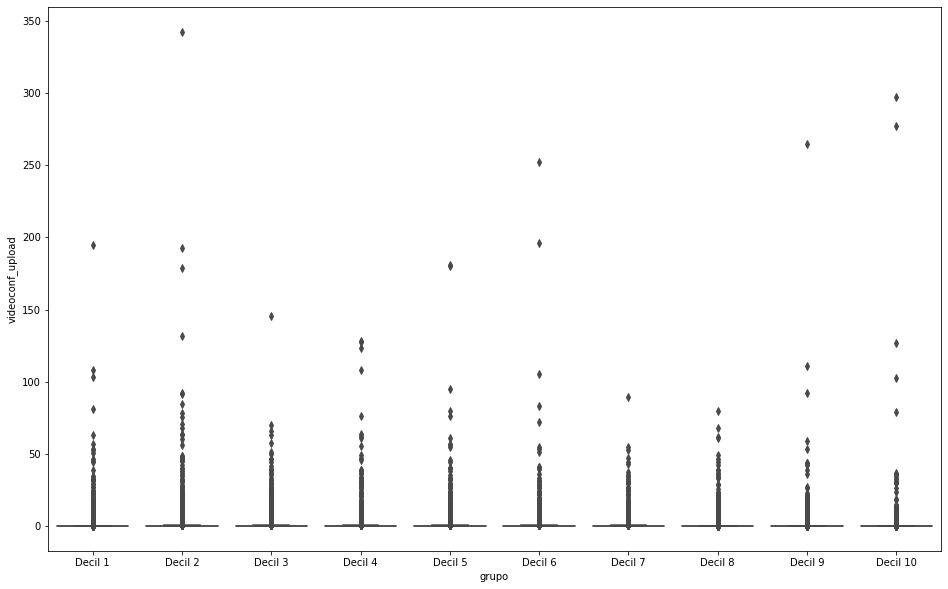

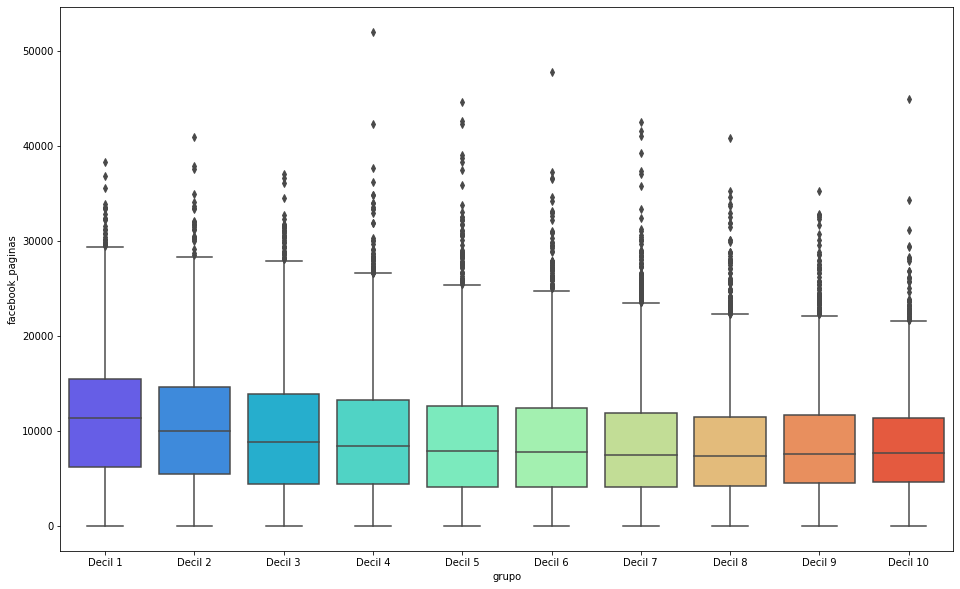

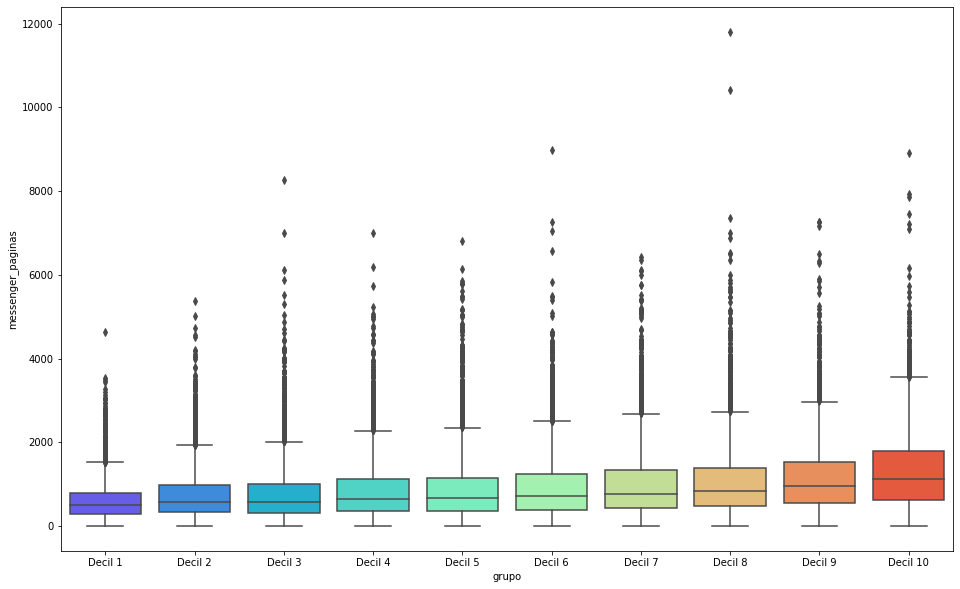

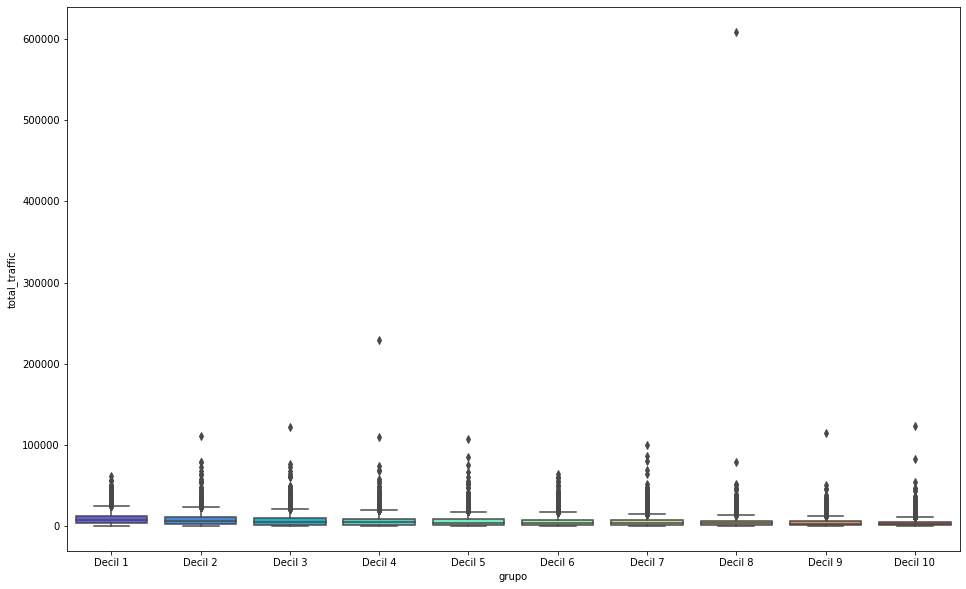

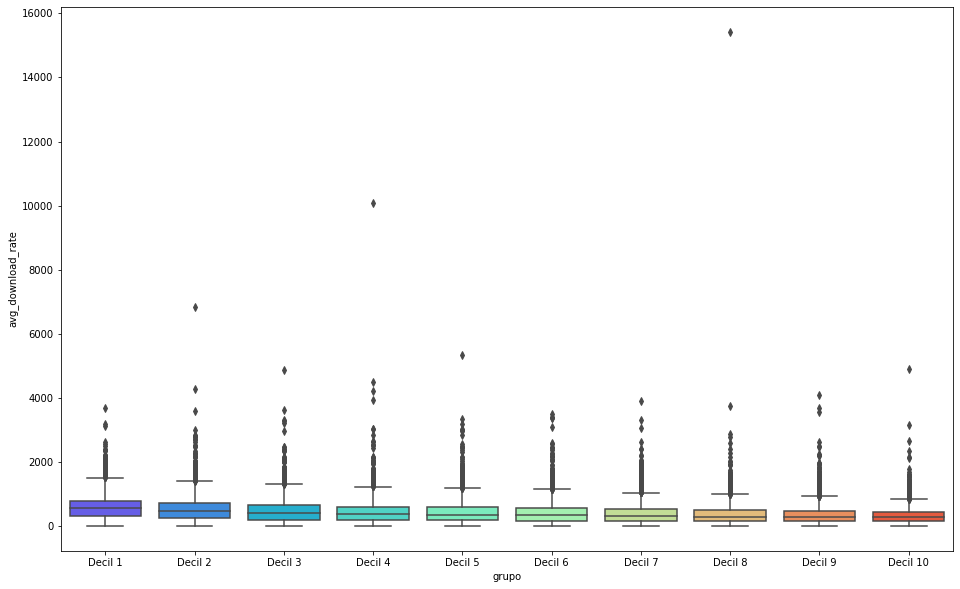

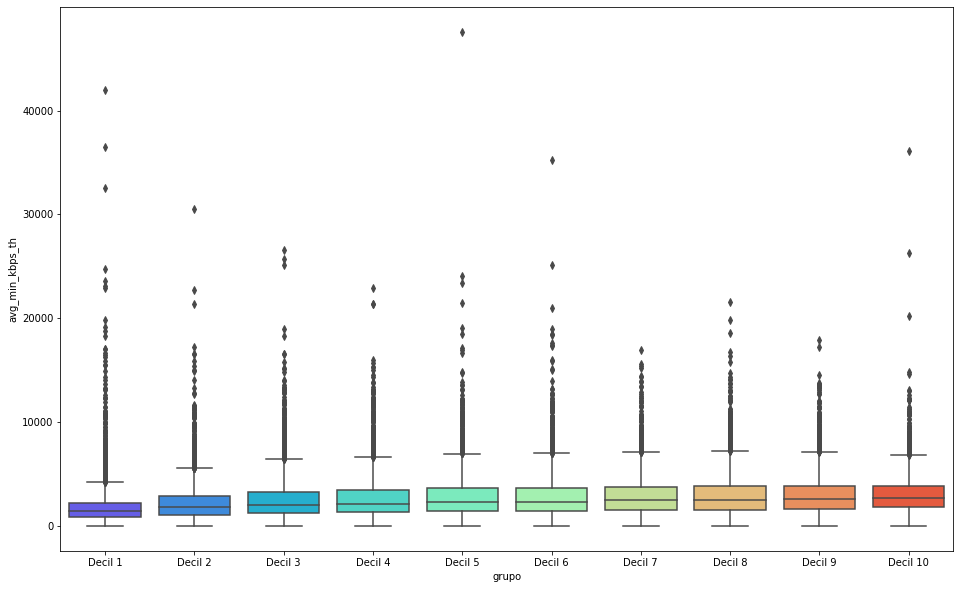

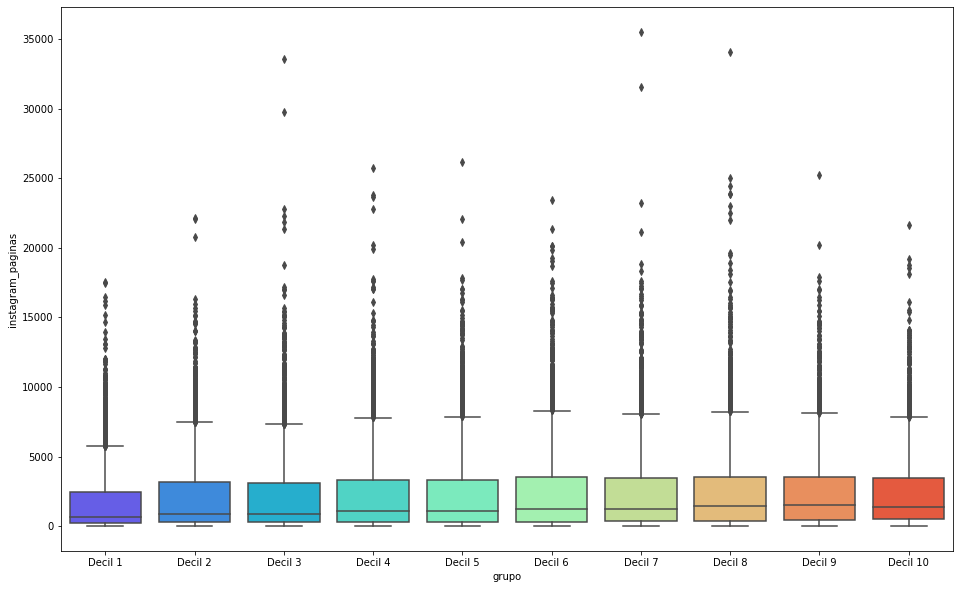

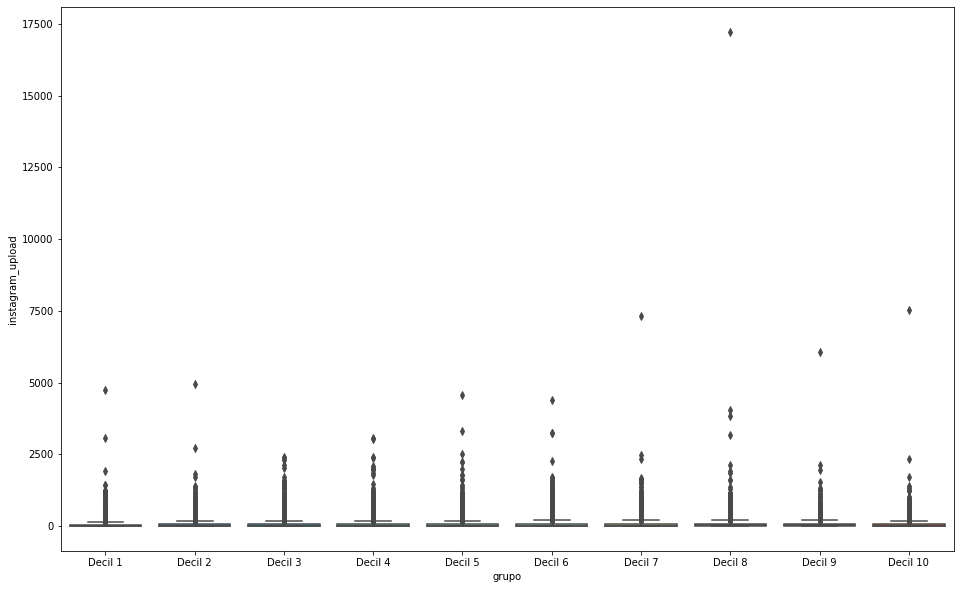

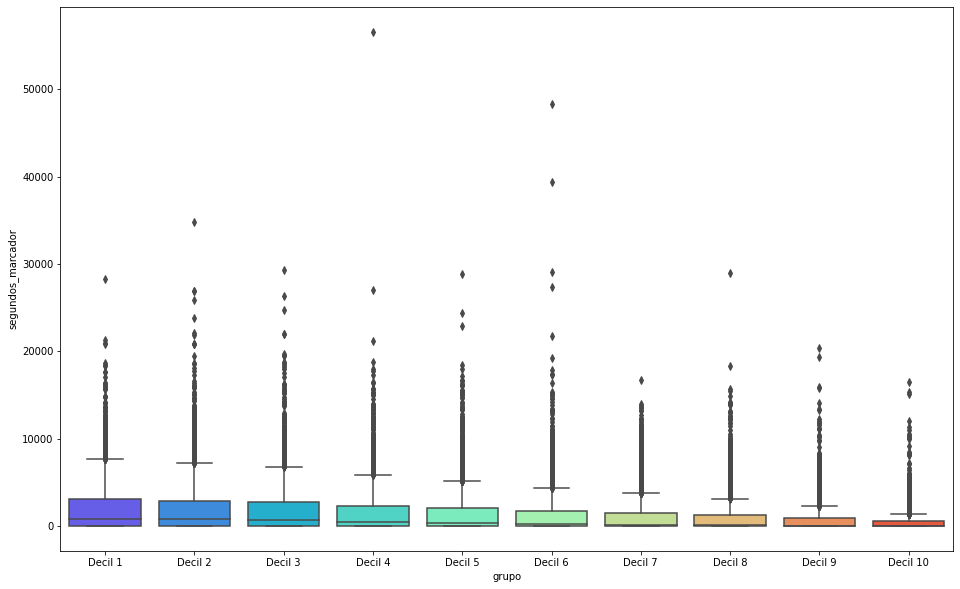

In [31]:
for var in numericas:
    plt.figure(figsize=(16,10))
    sns.boxplot(x='grupo',y=var,data=df_2, palette='rainbow',order=['Decil 1','Decil 2','Decil 3','Decil 4','Decil 5','Decil 6','Decil 7','Decil 8','Decil 9','Decil 10'])
    plt.show()

In [32]:
resumen3=pd.DataFrame()
deciles=['Decil 1','Decil 2','Decil 3','Decil 4','Decil 5','Decil 6','Decil 7','Decil 8','Decil 9','Decil 10','total']
df_3 =df.loc[df['target_out_m2']==0, :]
for var in numericas:
    r_mesactual_grupo = pd.DataFrame(group.describe().rename(columns={var:decil}).squeeze()
                            for decil, group in df_3.loc[:, [var,'grupo']].groupby('grupo'))
    r_mesactual_grupo = r_mesactual_grupo.append(df_3[var].describe(include='all'))
    r_mesactual_grupo = r_mesactual_grupo.rename(index={var: 'total'})
    r_mesactual_grupo.index.names = ['variables']
    #r_mesactual_grupo.reset_index(level=0, inplace=True)
    r_mesactual_grupo = r_mesactual_grupo.round(2)
    r_mesactual_grupo.rename(columns={'mean':var},inplace=True)
    resumen3=resumen3.append(np.round(r_mesactual_grupo.loc[deciles,var],2).T)

#resumen.to_csv('/home/userbda/Documents/Modelos/modelo_contactabilidad_Outbound/outputs/resumen_var/resumen.csv')
resumen3

,Decil 1,Decil 2,Decil 3,Decil 4,Decil 5,Decil 6,Decil 7,Decil 8,Decil 9,Decil 10,total
callcenter_llamadas,4.99,6.46,7.45,7.86,8.97,9.97,10.88,12.69,14.11,21.02,10.77
youtube_download,5499.19,4994.14,4520.89,4080.85,3786.74,3442.14,3206.35,2951.17,2586.70,2958.50,3744.31
segundos_baja_m_1,9456.48,9440.27,9010.21,8501.17,7949.02,7271.70,6390.70,5723.86,4596.62,3515.09,7038.43
segundos_baja,9619.04,9698.19,9328.46,8737.66,8206.97,7633.21,6696.22,5915.87,4634.26,3651.59,7261.05
spotify_paginas,226.65,256.75,257.48,256.83,267.52,263.92,262.77,255.47,220.99,206.66,246.55
callcenter_llamadas_m_1,4.54,5.74,6.32,6.56,7.40,8.20,9.16,10.40,11.79,18.42,9.13
segundos_alta,40867.29,44225.75,42571.52,40308.74,36852.07,35523.82,32648.38,28675.75,22818.51,18034.44,33635.03
videoconf_paginas,329.62,364.53,370.03,359.32,375.26,360.33,362.43,359.66,332.49,357.55,356.90
avg_traffic_median,6.63,6.75,6.76,6.72,6.56,6.47,6.48,6.42,5.78,5.99,6.44
llamadas_ent_m_1,138.71,133.36,123.56,110.55,102.31,95.64,85.40,77.38,65.89,53.70,96.68


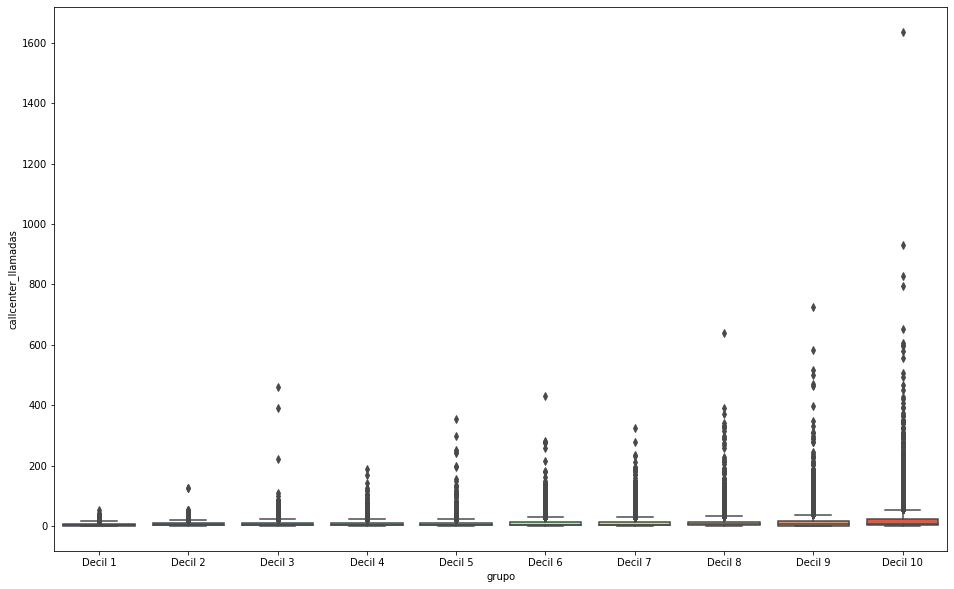

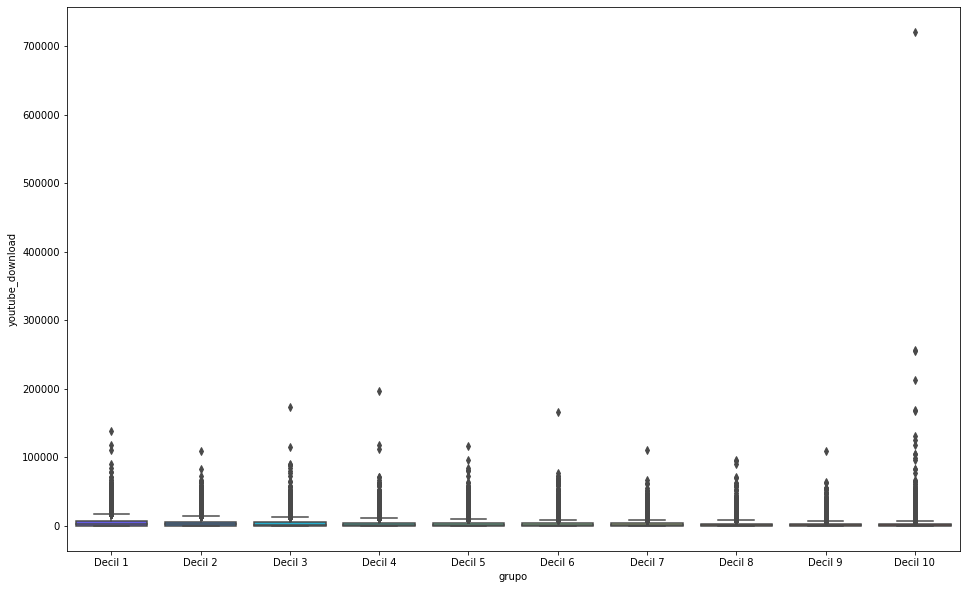

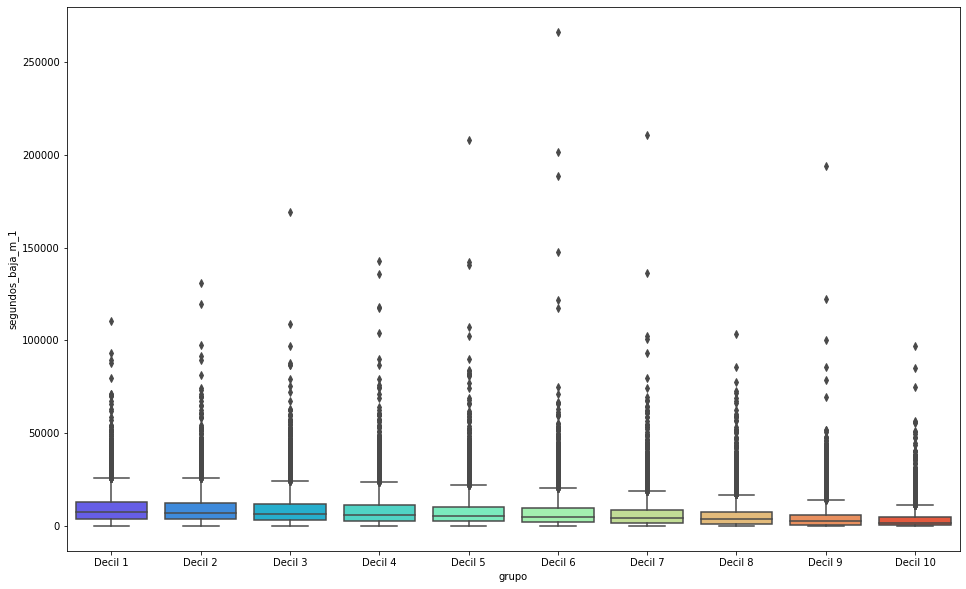

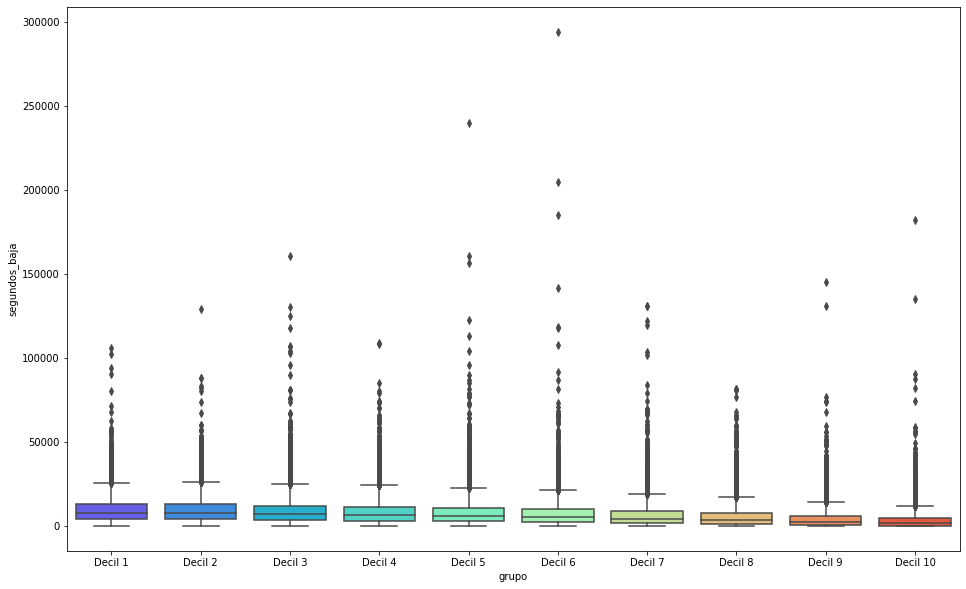

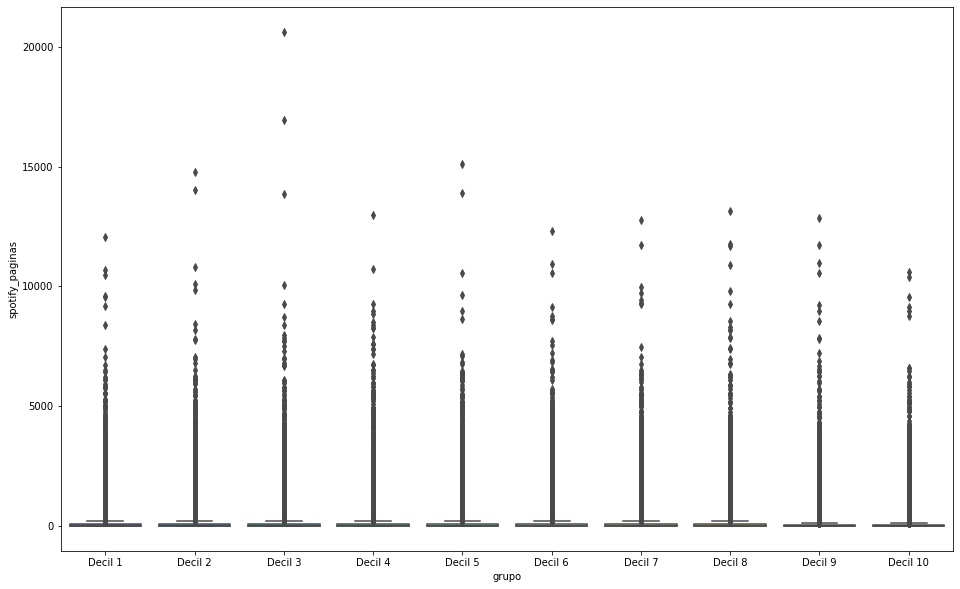

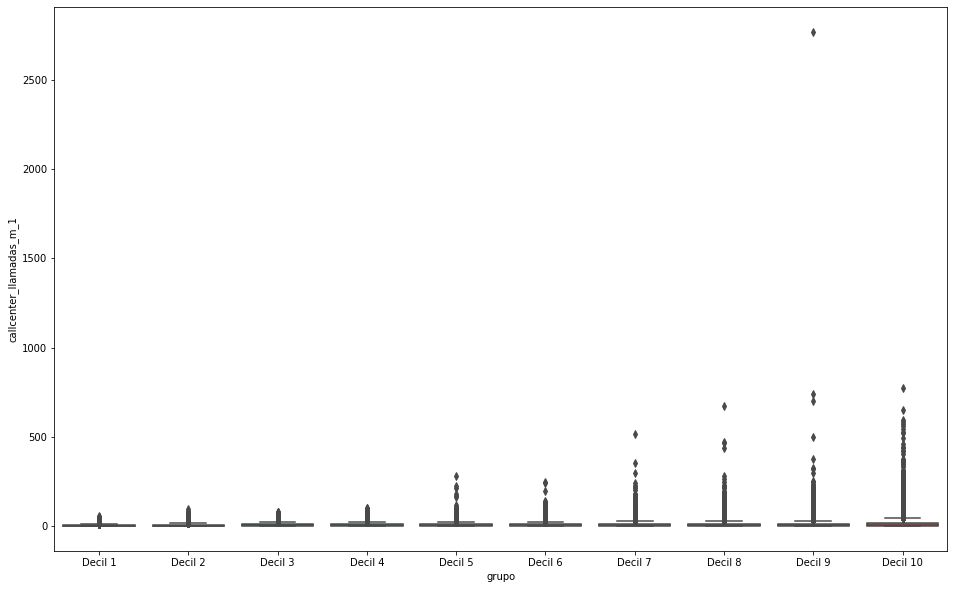

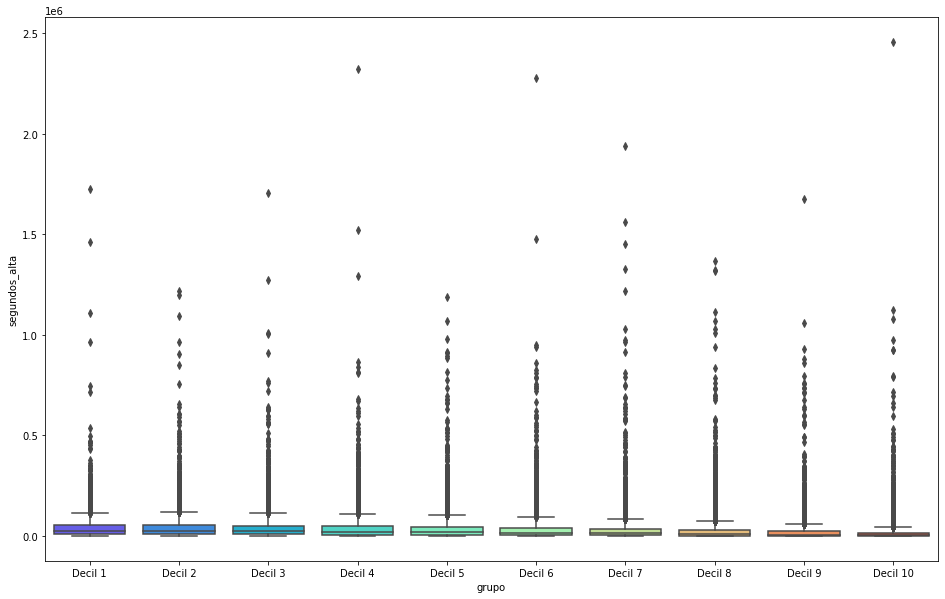

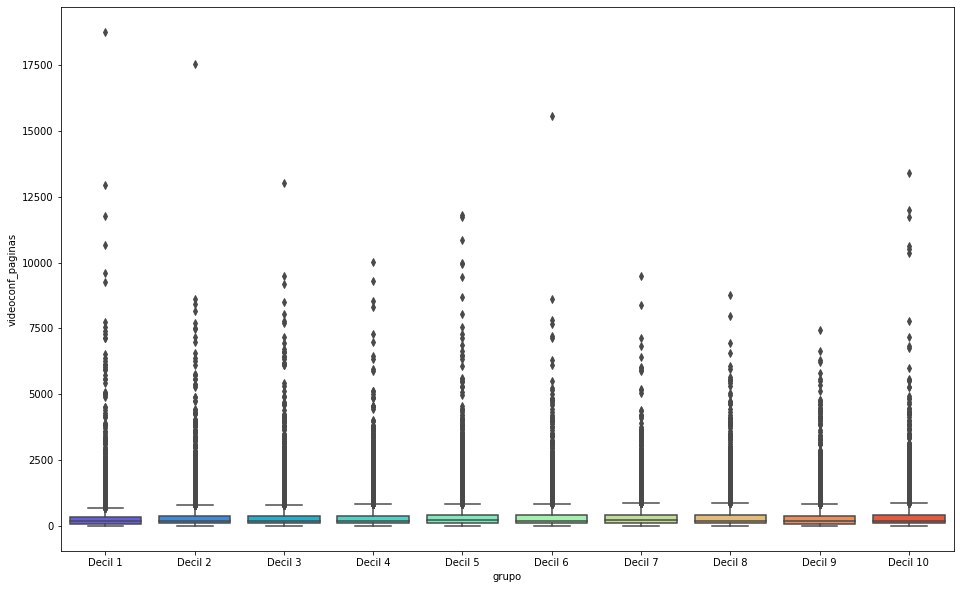

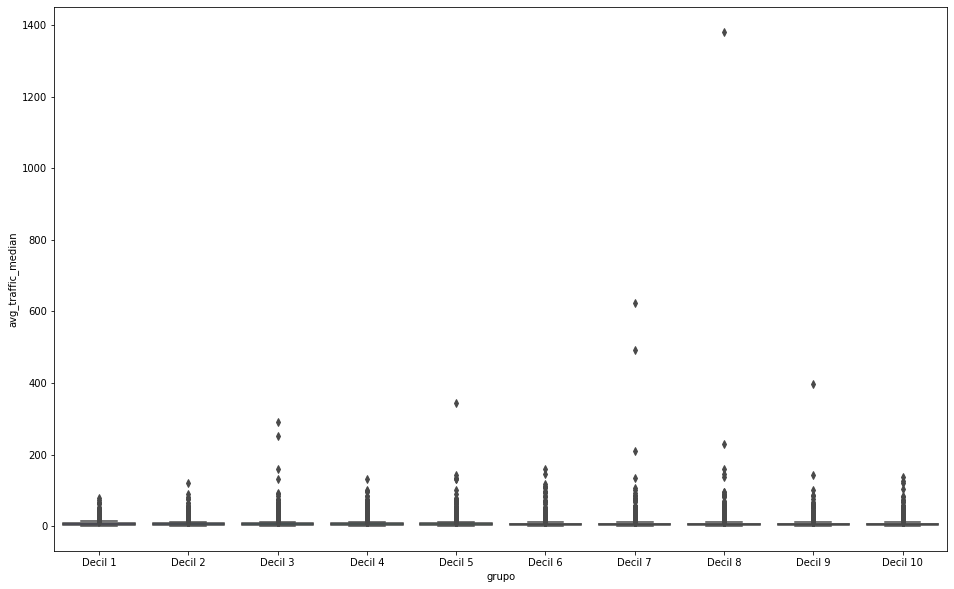

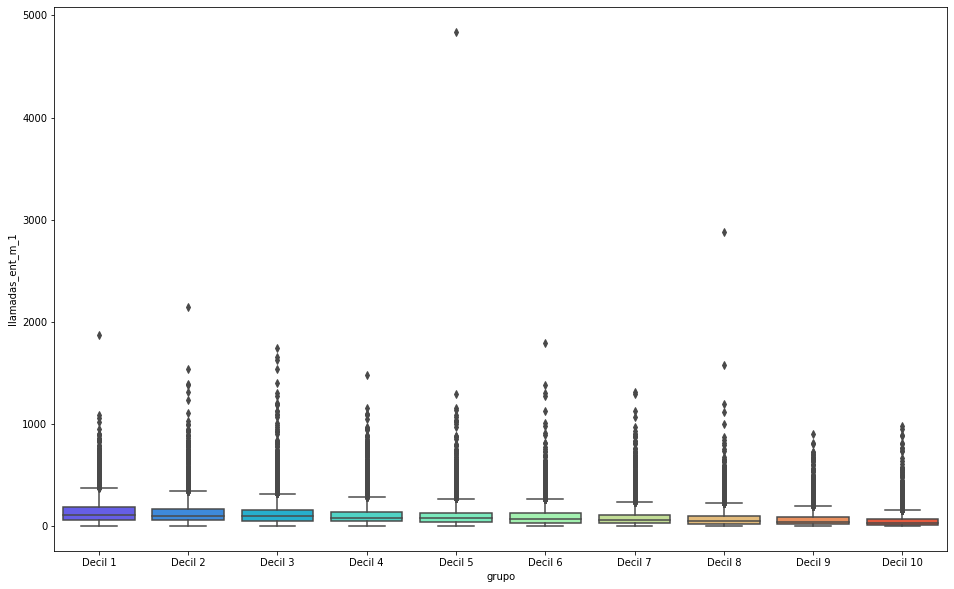

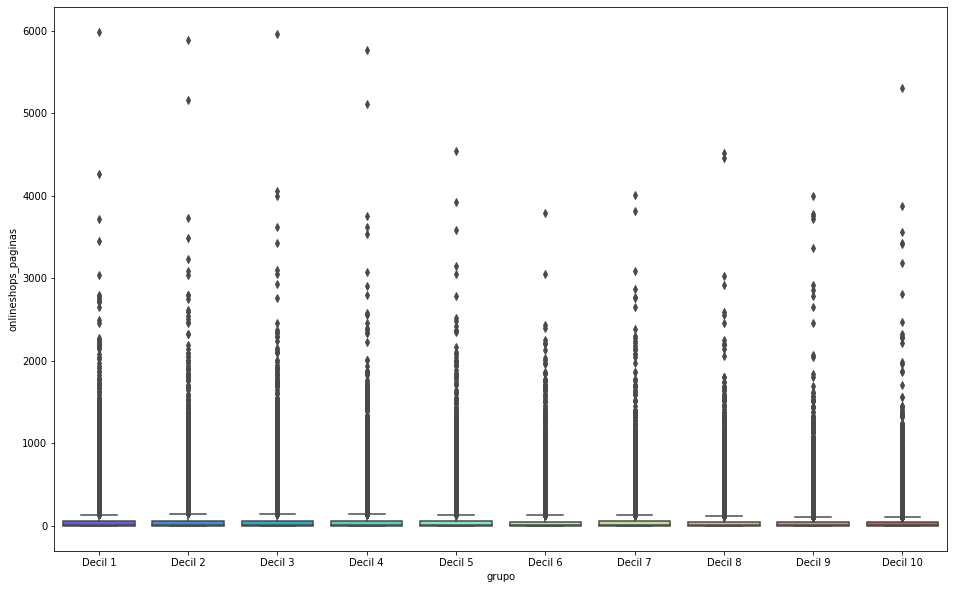

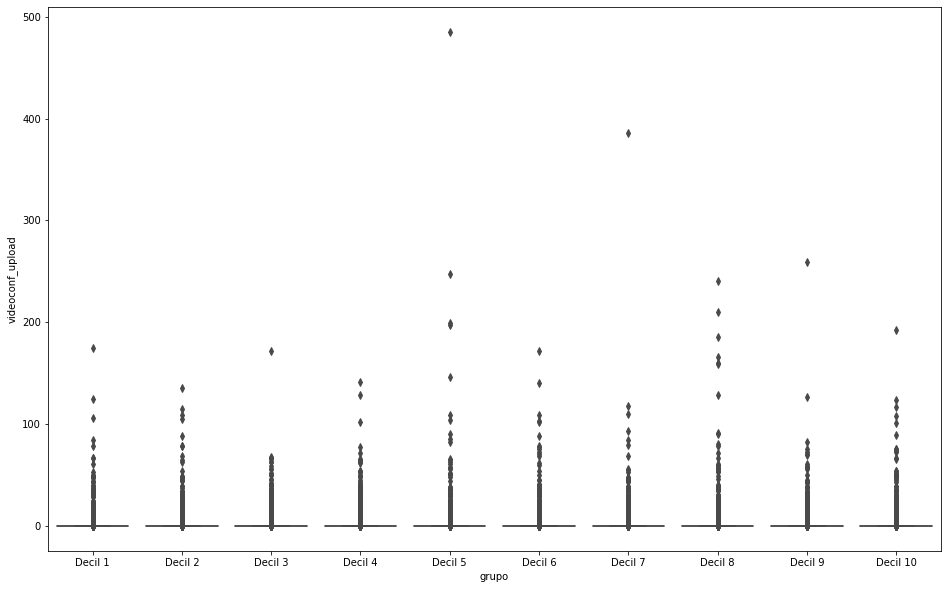

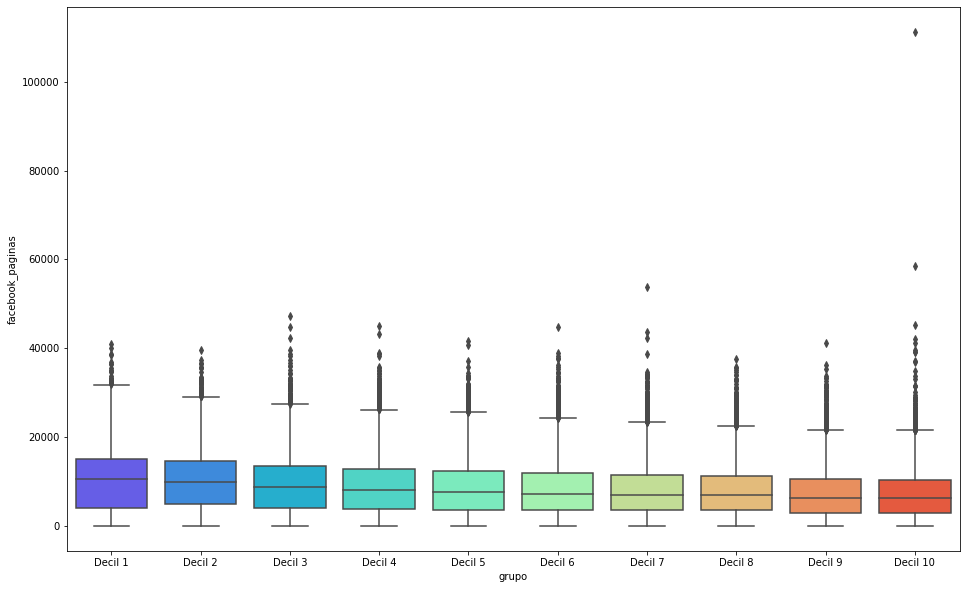

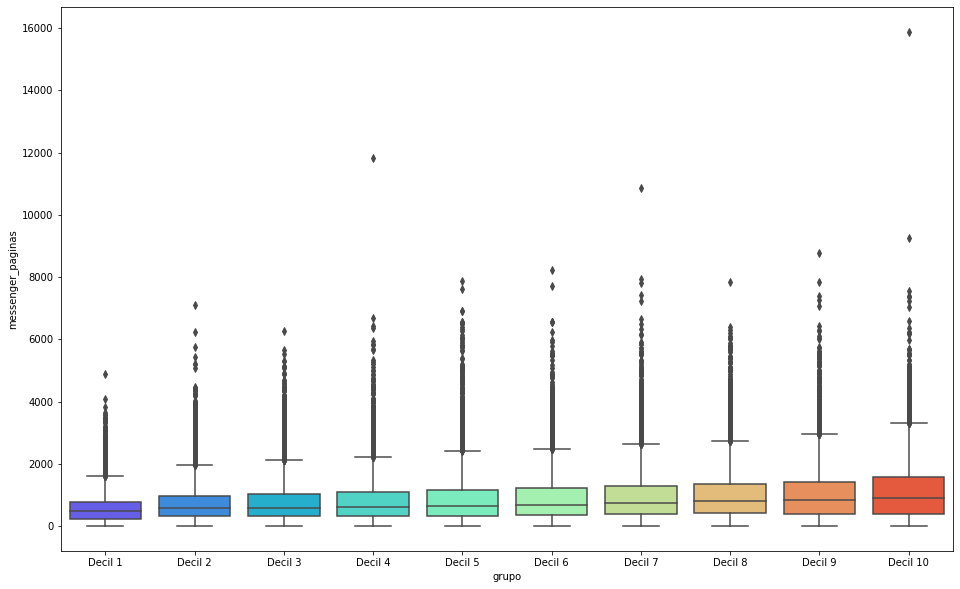

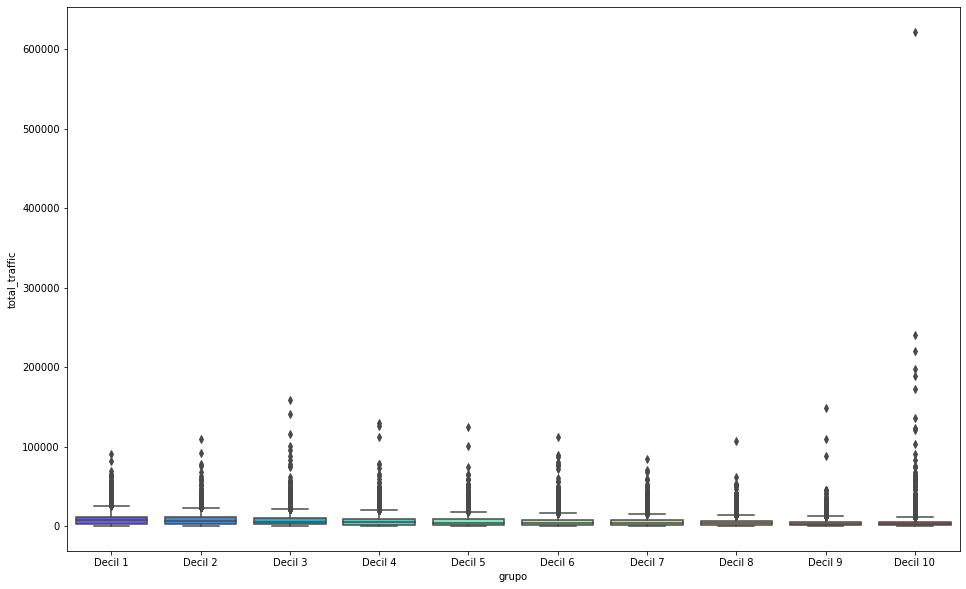

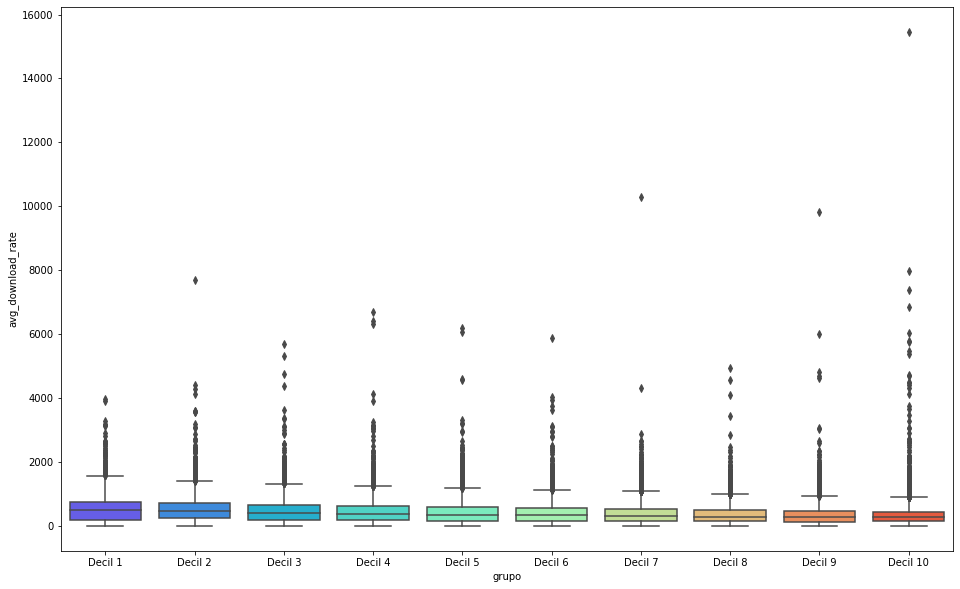

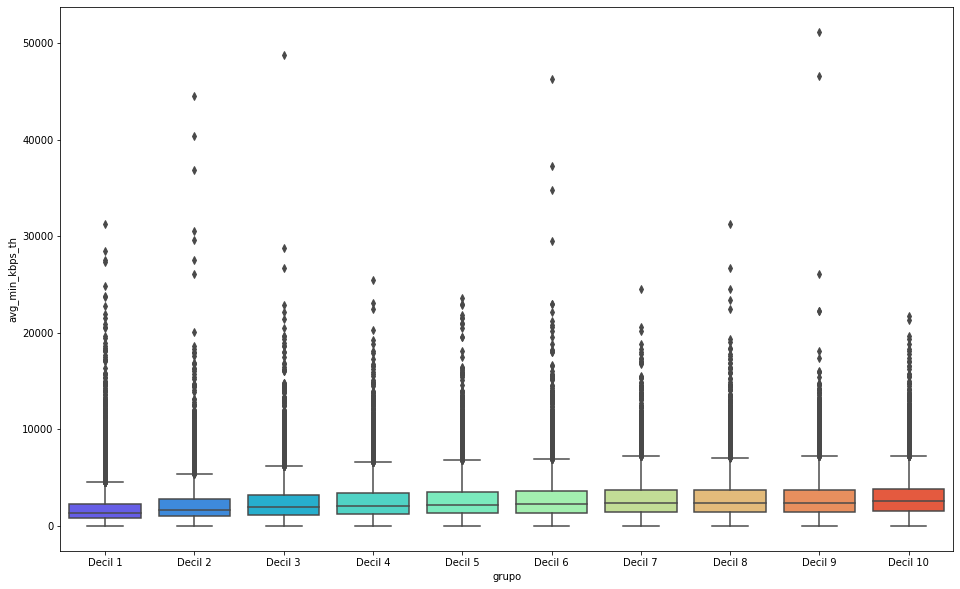

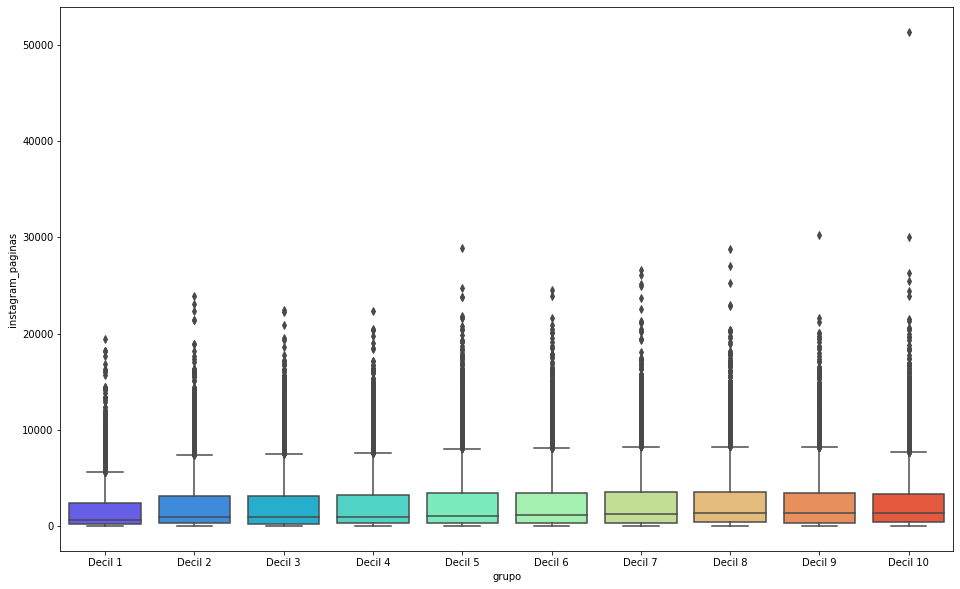

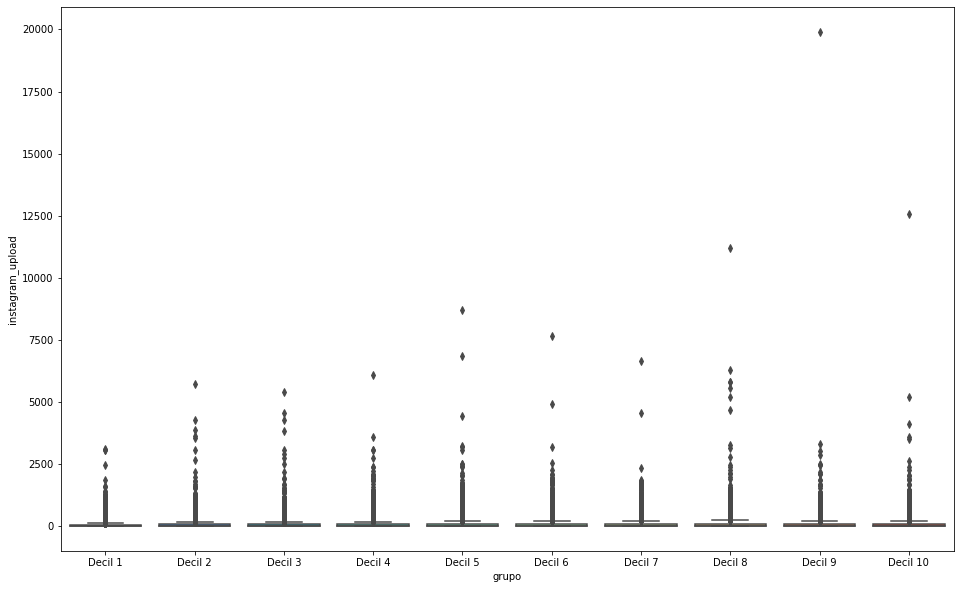

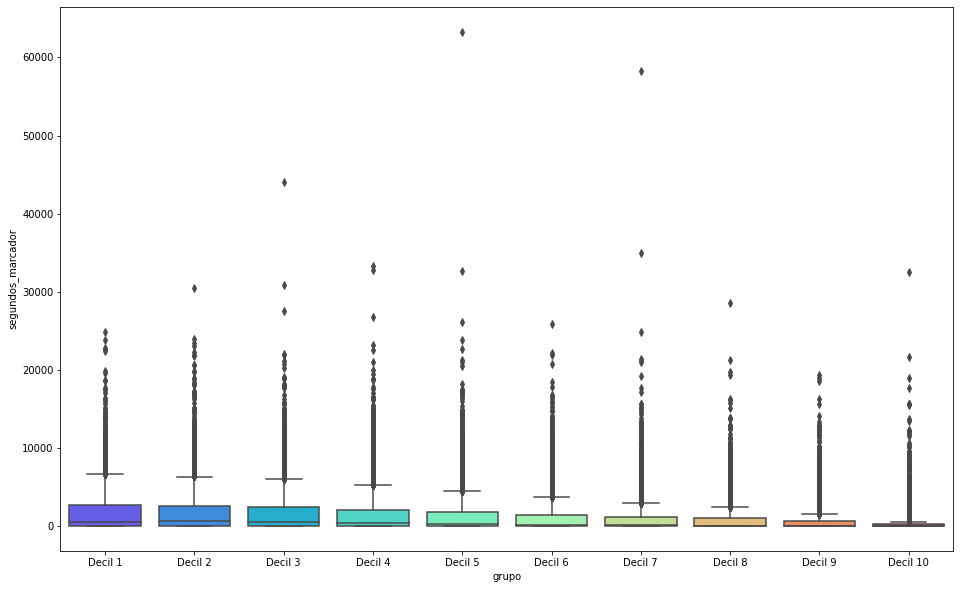

In [33]:
for var in numericas:
    plt.figure(figsize=(16,10))
    sns.boxplot(x='grupo',y=var,data=df_3, palette='rainbow',order=['Decil 1','Decil 2','Decil 3','Decil 4','Decil 5','Decil 6','Decil 7','Decil 8','Decil 9','Decil 10'])
    plt.show()

PSI
===

In [78]:
def calc_psi(ref, actual):
    return ((actual-ref)*np.log(actual/ref))/100

In [8]:
sql=f"""
select periodo, nro_telefono_hash,
nro_documento_hash,
{variables[0]},
{variables[1]},
{variables[2]},
{variables[3]},
{variables[4]},
{variables[5]},
{variables[6]},
{variables[7]},
{variables[8]},
{variables[9]},
{variables[10]},
{variables[11]},
{variables[12]},
{variables[13]},
{variables[14]},
{variables[15]},
{variables[16]},
{variables[17]},
{variables[18]},
{variables[19]},
target_out_2m
from 
public.PER_MODELO_CONTACT_OUT3
where periodo='2022-02-01'
and target_out_2m is not null
"""
df_temp = pd.read_sql_query(sql, engine)
df_score=pd.read_csv('../outputs/preds/res_202202_26-09-2022_21:40:36_v8_traf_m2.csv.gzip',compression='gzip')
df_0=df_temp.merge(df_score,how='left',on='nro_telefono_hash').drop(columns=['nro_documento_hash_y'])
df_0['grupo'] = pd.cut(df_0.pred,
        bins=[-1, df_0['pred'].quantile(0.1), df_0['pred'].quantile(0.2), df_0['pred'].quantile(0.3), 
        df_0['pred'].quantile(0.4), df_0['pred'].quantile(0.5), df_0['pred'].quantile(0.6), df_0['pred'].quantile(0.7),
        df_0['pred'].quantile(0.8),df_0['pred'].quantile(0.9), 1],
        labels=['Decil 10','Decil 9','Decil 8','Decil 7','Decil 6','Decil 5','Decil 4','Decil 3','Decil 2','Decil 1'])

In [9]:
sql=f"""
select periodo, nro_telefono_hash,
nro_documento_hash,
{variables[0]},
{variables[1]},
{variables[2]},
{variables[3]},
{variables[4]},
{variables[5]},
{variables[6]},
{variables[7]},
{variables[8]},
{variables[9]},
{variables[10]},
{variables[11]},
{variables[12]},
{variables[13]},
{variables[14]},
{variables[15]},
{variables[16]},
{variables[17]},
{variables[18]},
{variables[19]},
target_out_m2
from 
public.PER_MODELO_CONTACT_OUT3
where periodo='2022-03-01'
and target_out_m2 is not null
"""
df_temp = pd.read_sql_query(sql, engine)
df_score=pd.read_csv('../outputs/preds/res_202203_26-09-2022_21:39:37_v8_traf_m2.csv.gzip',compression='gzip')
df_1=df_temp.merge(df_score,how='left',on='nro_telefono_hash').drop(columns=['nro_documento_hash_y'])
df_1['grupo'] = pd.cut(df_1.pred,
        bins=[-1, df_1['pred'].quantile(0.1), df_1['pred'].quantile(0.2), df_1['pred'].quantile(0.3), 
        df_1['pred'].quantile(0.4), df_1['pred'].quantile(0.5), df_1['pred'].quantile(0.6), df_1['pred'].quantile(0.7),
        df_1['pred'].quantile(0.8),df_1['pred'].quantile(0.9), 1],
        labels=['Decil 10','Decil 9','Decil 8','Decil 7','Decil 6','Decil 5','Decil 4','Decil 3','Decil 2','Decil 1'])

In [10]:
sql=f"""
select periodo, nro_telefono_hash,
nro_documento_hash,
{variables[0]},
{variables[1]},
{variables[2]},
{variables[3]},
{variables[4]},
{variables[5]},
{variables[6]},
{variables[7]},
{variables[8]},
{variables[9]},
{variables[10]},
{variables[11]},
{variables[12]},
{variables[13]},
{variables[14]},
{variables[15]},
{variables[16]},
{variables[17]},
{variables[18]},
{variables[19]},
target_out_m2
from 
public.PER_MODELO_CONTACT_OUT3
where periodo='2022-04-01'
and target_out_m2 is not null
"""
df_temp = pd.read_sql_query(sql, engine)
df_score=pd.read_csv('../outputs/preds/res_202204_26-09-2022_21:37:27_v8_traf_m2.csv.gzip',compression='gzip')
df_2=df_temp.merge(df_score,how='left',on='nro_telefono_hash').drop(columns=['nro_documento_hash_y'])
df_2['grupo'] = pd.cut(df_2.pred,
        bins=[-1, df_2['pred'].quantile(0.1), df_2['pred'].quantile(0.2), df_2['pred'].quantile(0.3), 
        df_2['pred'].quantile(0.4), df_2['pred'].quantile(0.5), df_2['pred'].quantile(0.6), df_2['pred'].quantile(0.7),
        df_2['pred'].quantile(0.8),df_2['pred'].quantile(0.9), 1],
        labels=['Decil 10','Decil 9','Decil 8','Decil 7','Decil 6','Decil 5','Decil 4','Decil 3','Decil 2','Decil 1'])

In [11]:
sql=f"""
select periodo, nro_telefono_hash,
nro_documento_hash,
{variables[0]},
{variables[1]},
{variables[2]},
{variables[3]},
{variables[4]},
{variables[5]},
{variables[6]},
{variables[7]},
{variables[8]},
{variables[9]},
{variables[10]},
{variables[11]},
{variables[12]},
{variables[13]},
{variables[14]},
{variables[15]},
{variables[16]},
{variables[17]},
{variables[18]},
{variables[19]},
target_out_m2
from 
public.PER_MODELO_CONTACT_OUT3
where periodo='2022-05-01'
and target_out_m2 is not null
"""
df_temp = pd.read_sql_query(sql, engine)
df_score=pd.read_csv('../outputs/preds/res_202205_26-09-2022_21:35:45_v8_traf_m2.csv.gzip',compression='gzip')
df_3=df_temp.merge(df_score,how='left',on='nro_telefono_hash').drop(columns=['nro_documento_hash_y'])
df_3['grupo'] = pd.cut(df_3.pred,
        bins=[-1, df_3['pred'].quantile(0.1), df_3['pred'].quantile(0.2), df_3['pred'].quantile(0.3), 
        df_3['pred'].quantile(0.4), df_3['pred'].quantile(0.5), df_3['pred'].quantile(0.6), df_3['pred'].quantile(0.7),
        df_3['pred'].quantile(0.8),df_3['pred'].quantile(0.9), 1],
        labels=['Decil 10','Decil 9','Decil 8','Decil 7','Decil 6','Decil 5','Decil 4','Decil 3','Decil 2','Decil 1'])

In [12]:
sql=f"""
select periodo, nro_telefono_hash,
nro_documento_hash,
{variables[0]},
{variables[1]},
{variables[2]},
{variables[3]},
{variables[4]},
{variables[5]},
{variables[6]},
{variables[7]},
{variables[8]},
{variables[9]},
{variables[10]},
{variables[11]},
{variables[12]},
{variables[13]},
{variables[14]},
{variables[15]},
{variables[16]},
{variables[17]},
{variables[18]},
{variables[19]},
target_out_m2
from 
public.PER_MODELO_CONTACT_OUT3
where periodo='2022-06-01'
and target_out_m2 is not null
"""
df_temp = pd.read_sql_query(sql, engine)
df_score=pd.read_csv('../outputs/preds/res_202206_26-09-2022_21:33:57_v8_traf_m2.csv.gzip',compression='gzip')
df_4=df_temp.merge(df_score,how='left',on='nro_telefono_hash').drop(columns=['nro_documento_hash_y'])
df_4['grupo'] = pd.cut(df_4.pred,
        bins=[-1, df_4['pred'].quantile(0.1), df_4['pred'].quantile(0.2), df_4['pred'].quantile(0.3), 
        df_4['pred'].quantile(0.4), df_4['pred'].quantile(0.5), df_4['pred'].quantile(0.6), df_4['pred'].quantile(0.7),
        df_4['pred'].quantile(0.8),df_4['pred'].quantile(0.9), 1],
        labels=['Decil 10','Decil 9','Decil 8','Decil 7','Decil 6','Decil 5','Decil 4','Decil 3','Decil 2','Decil 1'])

In [13]:
def psi(score_initial, score_new, num_bins = 10, mode = 'fixed'):
    
    eps = 1e-4
    
    # Sort the data
    score_initial.sort_values()
    score_new.sort_values()
    
    # Prepare the bins
    min_val = min(min(score_initial), min(score_new))
    max_val = max(max(score_initial), max(score_new))
    if mode == 'fixed':
        bins = [min_val + (max_val - min_val)*(i)/num_bins for i in range(num_bins+1)]
    elif mode == 'quantile':
        bins = pd.qcut(score_initial, q = num_bins, retbins = True)[1] # Create the quantiles based on the initial population
    else:
        raise ValueError(f"Mode \'{mode}\' not recognized. Your options are \'fixed\' and \'quantile\'")
    bins[0] = min_val - eps # Correct the lower boundary
    bins[-1] = max_val + eps # Correct the higher boundary
        
        
    # Bucketize the initial population and count the sample inside each bucket
    bins_initial = pd.cut(score_initial, bins = bins, labels = range(1,num_bins+1))
    df_initial = pd.DataFrame({'initial': score_initial, 'bin': bins_initial})
    grp_initial = df_initial.groupby('bin').count()
    grp_initial['percent_initial'] = grp_initial['initial'] / sum(grp_initial['initial'])
    
    # Bucketize the new population and count the sample inside each bucket
    bins_new = pd.cut(score_new, bins = bins, labels = range(1,num_bins+1))
    df_new = pd.DataFrame({'new': score_new, 'bin': bins_new})
    grp_new = df_new.groupby('bin').count()
    grp_new['percent_new'] = grp_new['new'] / sum(grp_new['new'])
    
    # Compare the bins to calculate PSI
    psi_df = grp_initial.join(grp_new, on = "bin", how = "inner")
    
    # Add a small value for when the percent is zero
    psi_df['percent_initial'] = psi_df['percent_initial'].apply(lambda x: eps if x == 0 else x)
    psi_df['percent_new'] = psi_df['percent_new'].apply(lambda x: eps if x == 0 else x)
    
    # Calculate the psi
    psi_df['psi'] = (psi_df['percent_initial'] - psi_df['percent_new']) * np.log(psi_df['percent_initial'] / psi_df['percent_new'])
    
    # Return the psi values
    return psi_df['psi'].values

In [14]:

psi_quantile = pd.DataFrame(psi(df_0.pred,df_1.pred,mode = 'quantile').reshape(1,10))
psi_quantile = pd.concat([psi_quantile,
    pd.DataFrame(psi(df_0.pred,df_2.pred,mode = 'quantile').reshape(1,10)),
    pd.DataFrame(psi(df_0.pred,df_3.pred,mode = 'quantile').reshape(1,10)),
    pd.DataFrame(psi(df_0.pred,df_4.pred,mode = 'quantile').reshape(1,10))])
#psi_quantile = psi_quantile.append(psi(df_0.pred,df_3.pred,mode = 'quantile').reshape(1,10))
#psi_quantile = psi_quantile.append(psi(df_0.pred,df_4.pred,mode = 'quantile').reshape(1,10))
psi_quantile = psi_quantile.set_axis(['Decil 1','Decil 2','Decil 3','Decil 4','Decil 5','Decil 6','Decil 7','Decil 8','Decil 9','Decil 10'], axis=1, inplace=False)
psi_quantile

,Decil 1,Decil 2,Decil 3,Decil 4,Decil 5,Decil 6,Decil 7,Decil 8,Decil 9,Decil 10
0,0.000326,0.000188,0.000002,0.000110,0.000654,0.001187,0.001060,0.000349,0.000205,0.006888
0,0.080403,0.015893,0.003559,0.000304,0.000339,0.002827,0.006500,0.012361,0.022759,0.051516
0,0.055216,0.028395,0.011961,0.002969,0.000007,0.001597,0.007612,0.019924,0.042273,0.094096
0,0.062254,0.050160,0.027089,0.008983,0.000519,0.003054,0.019645,0.049917,0.108647,0.163320


In [15]:
psi_quantile = pd.DataFrame(psi(df_3.pred,df_4.pred,mode = 'quantile').reshape(1,10))
psi_quantile = psi_quantile.set_axis(['Decil 1','Decil 2','Decil 3','Decil 4','Decil 5','Decil 6','Decil 7','Decil 8','Decil 9','Decil 10'], axis=1, inplace=False)
psi_quantile

,Decil 1,Decil 2,Decil 3,Decil 4,Decil 5,Decil 6,Decil 7,Decil 8,Decil 9,Decil 10
0,0.000014,0.000336,0.002275,0.002234,0.001801,0.001402,0.000382,0.000285,0.005275,0.025032


In [16]:
psi_quantile = pd.DataFrame(psi(df_2.pred,df_3.pred,mode = 'quantile').reshape(1,10))
psi_quantile = psi_quantile.set_axis(['Decil 1','Decil 2','Decil 3','Decil 4','Decil 5','Decil 6','Decil 7','Decil 8','Decil 9','Decil 10'], axis=1, inplace=False)
psi_quantile

,Decil 1,Decil 2,Decil 3,Decil 4,Decil 5,Decil 6,Decil 7,Decil 8,Decil 9,Decil 10
0,0.007049,0.000069,0.000863,0.001894,0.002232,0.000908,0.000464,0.000057,0.001002,0.008114


In [17]:
psi_quantile = pd.DataFrame(psi(df_1.pred,df_2.pred,mode = 'quantile').reshape(1,10))
psi_quantile = psi_quantile.set_axis(['Decil 1','Decil 2','Decil 3','Decil 4','Decil 5','Decil 6','Decil 7','Decil 8','Decil 9','Decil 10'], axis=1, inplace=False)
psi_quantile

,Decil 1,Decil 2,Decil 3,Decil 4,Decil 5,Decil 6,Decil 7,Decil 8,Decil 9,Decil 10
0,0.093357,0.018307,0.00285,0.000013,0.002004,0.006602,0.011355,0.014727,0.018461,0.025078


In [18]:
psi_fixed = pd.DataFrame(psi(df_0.pred,df_1.pred).reshape(1,10))
psi_fixed = pd.concat([psi_fixed,
    pd.DataFrame(psi(df_0.pred,df_2.pred).reshape(1,10)),
    pd.DataFrame(psi(df_0.pred,df_3.pred).reshape(1,10)),
    pd.DataFrame(psi(df_0.pred,df_4.pred).reshape(1,10))])
#psi_quantile = psi_quantile.append(psi(df_0.pred,df_3.pred,mode = 'quantile').reshape(1,10))
#psi_quantile = psi_quantile.append(psi(df_0.pred,df_4.pred,mode = 'quantile').reshape(1,10))
psi_fixed = psi_fixed.set_axis(['Decil 1','Decil 2','Decil 3','Decil 4','Decil 5','Decil 6','Decil 7','Decil 8','Decil 9','Decil 10'], axis=1, inplace=False)
psi_fixed

,Decil 1,Decil 2,Decil 3,Decil 4,Decil 5,Decil 6,Decil 7,Decil 8,Decil 9,Decil 10
0,0.000013,0.000037,0.000018,0.000370,0.000261,0.000498,0.002479,0.001608,0.004839,0.000047
0,0.000448,0.009863,0.028396,0.038982,0.023745,0.000943,0.016200,0.049323,0.026159,0.000913
0,0.000012,0.001696,0.012116,0.037196,0.038406,0.005986,0.019313,0.088787,0.046301,0.002861
0,0.000006,0.001508,0.012414,0.042274,0.070097,0.018104,0.043935,0.218512,0.057781,0.001499


In [19]:
import numpy as np

def calculate_csi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables
    Args:
       expected: numpy matrix of original values (Training)
       actual: numpy matrix of new values, same size as expected (Validation)
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal
    Returns:
       psi_values: ndarray of psi values for each variable
    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def csi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable
        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into
        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = csi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = csi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = csi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [21]:
## Calculate csi for top features
csi_list = []
for feature in variables:
        # Assuming you have a validation and training set
        csi_t = calculate_csi(df_3[feature], df_0[feature])
        csi_list.append(csi_t)      
        #print(csi_t)
df_csi = pd.DataFrame(csi_list, columns= ["csi"])
df_csi.index = variables
df_csi

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


,csi
messenger_paginas,0.057507
callcenter_llamadas_m_1,0.000911
callcenter_llamadas,0.000993
segundos_baja_m_1,0.001429
segundos_baja,0.000047
videoconf_paginas,0.016884
instagram_paginas,0.194476
llamadas_ent_m_1,0.001100
spotify_paginas,0.001323
segundos_marcador,0.000187


In [22]:
## Calculate csi for top features
csi_list = []
for feature in variables:
        # Assuming you have a validation and training set
        csi_t = calculate_csi(df_4[feature], df_0[feature])
        csi_list.append(csi_t)      
        #print(csi_t)
df_csi = pd.DataFrame(csi_list, columns= ["csi"])
df_csi.index = variables
df_csi

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


,csi
messenger_paginas,0.088585
callcenter_llamadas_m_1,0.002560
callcenter_llamadas,0.001205
segundos_baja_m_1,0.001774
segundos_baja,0.000627
videoconf_paginas,0.013918
instagram_paginas,0.341921
llamadas_ent_m_1,0.001094
spotify_paginas,0.004396
segundos_marcador,0.000015


In [23]:
## Calculate csi for top features
csi_list = []
for feature in variables:
        # Assuming you have a validation and training set
        csi_t = calculate_csi(df_4[feature], df_3[feature])
        csi_list.append(csi_t)      
        #print(csi_t)
df_csi = pd.DataFrame(csi_list, columns= ["csi"])
df_csi.index = variables
df_csi

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


,csi
messenger_paginas,0.002068
callcenter_llamadas_m_1,0.001230
callcenter_llamadas,0.000787
segundos_baja_m_1,0.000608
segundos_baja,0.000861
videoconf_paginas,0.000130
instagram_paginas,0.009921
llamadas_ent_m_1,0.000260
spotify_paginas,0.001533
segundos_marcador,0.000315
